# SSCx Dissemination.

We analyze circuits developed under the SSCx Dissemination project.


In [134]:
from collections import OrderedDict
from tqdm import tqdm
from dmt.tk.plotting import Bars, LinePlot, Crosses
from dmt.data.observation import measurement
from dmt.tk.plotting.multi import MultiPlot
from neuro_dmt.models.bluebrain.circuit.geometry import Cuboid
from neuro_dmt.library.users.visood.sscx_dissemination.analyses import *

While using this notebook for development, we might need to reload the adapter:

In [135]:
sscxdiss = SSCxDisseminationCircuit()

In [136]:
sscxdiss.variations

bio0: Not Available
bio1: Not Available
bio2: Not Available
bio3: Not Available
bio4: Not Available
bio5: Not Available
biom: 'Bio_M/20191206'
mock: 'MOCK'

We will need to parameterize our analysis:

In [137]:
spec = AnalysisParameterization()
spec.field_dict

{'morphologies_interneurons': ['BP',
  'BTC',
  'CHC',
  'DB',
  'LBC',
  'NBC',
  'MC',
  'SBC',
  'SSC'],
 'number_cortical_thickness_bins': 50,
 'path_reports': '/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports',
 'sample_size': 100,
 'size_roi': array([50., 50., 50.])}

In [141]:
circuit_model = sscxdiss.circuit(sscxdiss.variations.mock)
#circuit_model = sscxdiss.circuit(sscxdiss.variations.biom)
adapter = sscxdiss.adapter

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/__init__.py
	lineno: 	138
	code_context: 	['        __log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 2
with number of excitatory mtypes: 1

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/__init__.py
	lineno: 	138
	code_context: 	['        __log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 3
with number of excitatory mtypes: 1

test develop mock circuit Logger                                    

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 4
with number of excitatory mtypes: 1

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 5
with number of excitatory mtypes: 3

test develop mock circuit Logger                    

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 6
with number of excitatory mtypes: 4

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 6
with number of excitatory mtypes: 4

test develop mock circuit Logger                    

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 6
with number of excitatory mtypes: 4

test develop mock circuit Logger                                                
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/test/mock_circuit_light.py
	lineno: 	107
	code_context: 	['        log.get_source_info(),\n']
	index: 0

get excitatory cell density for layer 6
with number of excitatory mtypes: 4

test develop mock circuit Logger                    






0it [00:00, ?it/s]




38it [00:00, 374.82it/s]

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/mock/builder.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Mock circuit builder: get_connectome(...)








76it [00:00, 373.72it/s]




115it [00:00, 377.78it/s]




158it [00:00, 389.83it/s]




201it [00:00, 400.57it/s]




236it [00:00, 382.46it/s]




276it [00:00, 387.46it/s]




314it [00:00, 385.19it/s]




356it [00:00, 394.73it/s]




397it [00:01, 398.61it/s]




440it [00:01, 406.59it/s]




485it [00:01, 416.80it/s]




530it [00:01, 425.01it/s]




575it [00:01, 431.84it/s]




619it [00:01, 422.35it/s]




662it [00:01, 416.82it/s]




705it [00:01, 418.40it/s]




748it [00:01, 420.45it/s]




793it [00:01, 427.07it/s]




836it [00:02, 425.26it/s]




879it [00:02, 424.84it/s]




922it [00:02, 425.27it/s]




965it [00:02, 422.22it/s]




1008it [00:02, 424.23it/s]




1052it [00:02, 428.48it/s]




1095it [00:02, 394.88it/s]




1136it [00:02, 396.37it/s]




1179it [00:02, 405.73it/s]




1222it [00:02, 410.66it/s]




1265it [00:03, 414.43it/s]




1310it [00:03, 422.62it/s]




1353it [00:03, 424.05it/s]




1396it [00:03, 414.57it/s]




1439it [00:03, 416.55it/s]

7618it [00:18, 405.35it/s]




7659it [00:18, 398.49it/s]




7701it [00:18, 402.52it/s]




7742it [00:19, 404.06it/s]




7784it [00:19, 407.90it/s]




7827it [00:19, 412.39it/s]




7869it [00:19, 407.09it/s]




7911it [00:19, 410.59it/s]




7953it [00:19, 401.58it/s]




7995it [00:19, 405.30it/s]




8040it [00:19, 416.06it/s]




8083it [00:19, 418.62it/s]




8125it [00:19, 418.28it/s]




8167it [00:20, 408.45it/s]




8208it [00:20, 408.10it/s]




8251it [00:20, 413.03it/s]




8293it [00:20, 414.95it/s]




8337it [00:20, 420.70it/s]




8380it [00:20, 418.54it/s]




8422it [00:21, 203.28it/s]




8457it [00:21, 232.21it/s]




8502it [00:21, 271.17it/s]




8543it [00:21, 300.42it/s]




8586it [00:21, 330.24it/s]




8630it [00:21, 356.40it/s]




8671it [00:21, 364.05it/s]




8713it [00:21, 378.74it/s]




8756it [00:21, 392.26it/s]




8798it [00:21, 398.82it/s]




8840it [00:22, 400.56it/s]




8882it [00:22, 404.46it/s]




8925it [00:22, 410.48it/s]




8967it [

15008it [00:37, 403.14it/s]




15050it [00:37, 407.32it/s]




15091it [00:37, 405.50it/s]




15132it [00:37, 395.08it/s]




15175it [00:37, 404.92it/s]




15217it [00:37, 407.76it/s]




15259it [00:37, 410.92it/s]




15301it [00:38, 410.18it/s]




15343it [00:38, 411.16it/s]




15385it [00:38, 410.69it/s]




15427it [00:38, 409.68it/s]




15468it [00:38, 408.93it/s]




15509it [00:38, 388.44it/s]




15549it [00:38, 390.83it/s]




15592it [00:38, 400.79it/s]




15636it [00:38, 410.98it/s]




15680it [00:39, 418.61it/s]




15723it [00:39, 418.49it/s]




15767it [00:39, 424.25it/s]




15810it [00:39, 422.88it/s]




15854it [00:39, 426.74it/s]




15901it [00:39, 436.82it/s]




15945it [00:39, 406.65it/s]




15987it [00:39, 405.41it/s]




16030it [00:39, 411.56it/s]




16076it [00:39, 423.58it/s]




16119it [00:40, 422.54it/s]




16162it [00:40, 414.37it/s]




16204it [00:40, 411.11it/s]




16246it [00:40, 411.74it/s]




16291it [00:40, 420.22it/s]




16334it 

22315it [00:55, 409.60it/s]




22357it [00:55, 405.84it/s]




22400it [00:55, 411.35it/s]




22442it [00:55, 395.28it/s]




22483it [00:56, 398.33it/s]




22524it [00:56, 401.72it/s]




22565it [00:56, 399.73it/s]




22606it [00:56, 399.59it/s]




22647it [00:56, 394.12it/s]




22690it [00:56, 402.36it/s]




22731it [00:56, 373.89it/s]




22775it [00:56, 390.96it/s]




22816it [00:56, 395.03it/s]




22862it [00:56, 410.71it/s]




22904it [00:57, 411.61it/s]




22946it [00:57, 410.35it/s]




22988it [00:57, 409.12it/s]




23030it [00:57, 393.05it/s]




23074it [00:57, 405.97it/s]




23117it [00:57, 412.71it/s]




23159it [00:57, 412.17it/s]




23201it [00:57, 412.18it/s]




23243it [00:57, 407.45it/s]




23285it [00:57, 410.95it/s]




23327it [00:58, 413.36it/s]




23369it [00:58, 404.16it/s]




23410it [00:58, 396.14it/s]




23451it [00:58, 398.15it/s]




23493it [00:58, 402.96it/s]




23536it [00:58, 408.79it/s]




23577it [00:58, 408.56it/s]




23618it 

29659it [01:14, 409.39it/s]




29701it [01:14, 411.78it/s]




29743it [01:14, 401.16it/s]




29784it [01:14, 401.78it/s]




29825it [01:14, 395.39it/s]




29865it [01:14, 389.19it/s]




29909it [01:14, 401.75it/s]




29952it [01:14, 407.94it/s]




29993it [01:14, 407.46it/s]




30034it [01:15, 404.57it/s]




30075it [01:15, 402.90it/s]




30116it [01:15, 401.59it/s]




30157it [01:15, 401.47it/s]




30201it [01:15, 409.79it/s]




30243it [01:15, 389.71it/s]




30284it [01:15, 393.62it/s]




30328it [01:15, 405.71it/s]




30373it [01:15, 417.09it/s]




30417it [01:16, 421.89it/s]




30462it [01:16, 427.65it/s]




30505it [01:16, 418.27it/s]




30547it [01:16, 415.30it/s]




30589it [01:16, 416.28it/s]




30631it [01:16, 416.34it/s]




30673it [01:16, 404.20it/s]




30714it [01:16, 405.13it/s]




30756it [01:16, 407.09it/s]




30797it [01:16, 406.90it/s]




30841it [01:17, 415.93it/s]




30883it [01:17, 416.24it/s]




30926it [01:17, 418.93it/s]




30968it 

36382it [01:32, 342.56it/s]




36419it [01:32, 348.24it/s]




36455it [01:32, 347.27it/s]




36490it [01:32, 347.88it/s]




36525it [01:33, 338.82it/s]




36565it [01:33, 353.43it/s]




36602it [01:33, 356.09it/s]




36638it [01:33, 354.40it/s]




36675it [01:33, 358.10it/s]




36711it [01:33, 327.42it/s]




36745it [01:33, 328.99it/s]




36780it [01:33, 332.98it/s]




36814it [01:33, 330.52it/s]




36848it [01:34, 333.03it/s]




36882it [01:34, 334.61it/s]




36920it [01:34, 346.49it/s]




36956it [01:34, 348.56it/s]




36992it [01:34, 350.56it/s]




37030it [01:34, 356.97it/s]




37066it [01:34, 334.91it/s]




37101it [01:34, 338.25it/s]




37137it [01:34, 343.48it/s]




37172it [01:34, 344.22it/s]




37208it [01:35, 347.40it/s]




37244it [01:35, 347.13it/s]




37287it [01:35, 367.38it/s]




37326it [01:35, 372.90it/s]




37366it [01:35, 380.37it/s]




37405it [01:35, 383.06it/s]




37444it [01:35, 365.60it/s]




37481it [01:35, 335.64it/s]




37516it 

42722it [01:51, 336.02it/s]




42756it [01:51, 330.35it/s]




42794it [01:51, 342.81it/s]




42829it [01:51, 331.74it/s]




42867it [01:51, 343.65it/s]




42904it [01:51, 350.99it/s]




42940it [01:51, 327.59it/s]




42978it [01:51, 341.46it/s]




43015it [01:51, 348.60it/s]




43051it [01:51, 343.58it/s]




43088it [01:52, 350.93it/s]




43127it [01:52, 359.30it/s]




43164it [01:52, 357.99it/s]




43200it [01:52, 351.39it/s]




43236it [01:52, 353.06it/s]




43275it [01:52, 363.38it/s]




43312it [01:52, 352.75it/s]




43348it [01:52, 353.45it/s]




43384it [01:52, 346.35it/s]




43420it [01:53, 350.10it/s]




43457it [01:53, 355.11it/s]




43493it [01:53, 347.59it/s]




43528it [01:53, 347.09it/s]




43563it [01:53, 346.99it/s]




43598it [01:53, 338.79it/s]




43632it [01:53, 324.32it/s]




43673it [01:53, 339.61it/s]




43713it [01:53, 353.94it/s]




43754it [01:53, 367.39it/s]




43800it [01:54, 389.13it/s]




43840it [01:54, 379.47it/s]




43880it 

48982it [02:10, 339.04it/s]




49023it [02:10, 355.94it/s]




49064it [02:10, 369.36it/s]




49102it [02:10, 358.37it/s]




49139it [02:10, 346.63it/s]




49174it [02:10, 307.75it/s]




49216it [02:10, 328.62it/s]




49257it [02:10, 347.78it/s]




49300it [02:10, 368.45it/s]




49341it [02:11, 379.43it/s]




49380it [02:11, 365.76it/s]




49418it [02:11, 349.16it/s]




49454it [02:11, 341.69it/s]




49491it [02:11, 349.00it/s]




49527it [02:11, 339.55it/s]




49568it [02:11, 357.75it/s]




49608it [02:11, 367.44it/s]




49646it [02:11, 348.70it/s]




49682it [02:12, 339.35it/s]




49723it [02:12, 356.67it/s]




49763it [02:12, 367.40it/s]




49801it [02:12, 367.25it/s]




49841it [02:12, 375.46it/s]




49879it [02:12, 345.40it/s]




49915it [02:12, 312.13it/s]




49953it [02:12, 329.40it/s]




49993it [02:12, 347.70it/s]




50032it [02:13, 357.50it/s]




50072it [02:13, 368.71it/s]




50110it [02:13, 351.56it/s]




50146it [02:13, 336.48it/s]




50181it 

55385it [02:28, 387.54it/s]




55424it [02:28, 375.29it/s]




55462it [02:28, 342.08it/s]




55505it [02:28, 362.85it/s]




55547it [02:29, 378.24it/s]




55587it [02:29, 376.67it/s]




55626it [02:29, 357.53it/s]




55663it [02:29, 344.56it/s]




55698it [02:29, 340.86it/s]




55736it [02:29, 350.60it/s]




55775it [02:29, 360.10it/s]




55821it [02:29, 384.51it/s]




55861it [02:29, 382.63it/s]




55902it [02:29, 389.25it/s]




55942it [02:30, 389.81it/s]




55982it [02:30, 383.94it/s]




56021it [02:30, 382.70it/s]




56060it [02:30, 378.93it/s]




56099it [02:30, 382.11it/s]




56138it [02:30, 352.28it/s]




56174it [02:30, 347.18it/s]




56213it [02:30, 355.66it/s]




56249it [02:30, 352.95it/s]




56289it [02:31, 364.37it/s]




56326it [02:31, 361.36it/s]




56365it [02:31, 368.84it/s]




56403it [02:31, 352.64it/s]




56442it [02:31, 362.33it/s]




56481it [02:31, 369.32it/s]




56519it [02:31, 344.08it/s]




56557it [02:31, 352.66it/s]




56593it 

61912it [02:47, 347.96it/s]




61947it [02:47, 339.16it/s]




61986it [02:47, 351.14it/s]




62022it [02:47, 351.17it/s]




62060it [02:47, 358.64it/s]




62097it [02:47, 354.62it/s]




62133it [02:47, 342.71it/s]




62168it [02:47, 338.32it/s]




62207it [02:47, 351.61it/s]




62248it [02:47, 365.60it/s]




62288it [02:48, 373.67it/s]




62326it [02:48, 373.56it/s]




62364it [02:48, 357.17it/s]




62400it [02:48, 346.30it/s]




62435it [02:48, 341.29it/s]




62470it [02:48, 307.14it/s]




62506it [02:48, 319.74it/s]




62544it [02:48, 333.85it/s]




62581it [02:48, 342.87it/s]




62617it [02:49, 346.57it/s]




62653it [02:49, 341.18it/s]




62688it [02:49, 329.72it/s]




62727it [02:49, 344.11it/s]




62765it [02:49, 352.39it/s]




62803it [02:49, 359.06it/s]




62840it [02:49, 324.78it/s]




62874it [02:49, 327.40it/s]




62908it [02:49, 330.86it/s]




62943it [02:50, 335.73it/s]




62982it [02:50, 350.17it/s]




63019it [02:50, 353.82it/s]




63055it 

68142it [03:06, 366.44it/s]




68180it [03:06, 362.93it/s]




68222it [03:06, 377.05it/s]




68262it [03:06, 382.81it/s]




68301it [03:06, 371.60it/s]




68340it [03:06, 376.85it/s]




68385it [03:06, 395.77it/s]




68426it [03:06, 375.61it/s]




68465it [03:07, 359.75it/s]




68502it [03:07, 353.21it/s]




68538it [03:07, 351.60it/s]




68574it [03:07, 353.94it/s]




68610it [03:07, 354.82it/s]




68646it [03:07, 330.49it/s]




68681it [03:07, 334.66it/s]




68715it [03:07, 333.99it/s]




68749it [03:07, 334.55it/s]




68788it [03:08, 348.94it/s]




68827it [03:08, 357.59it/s]




68867it [03:08, 368.33it/s]




68905it [03:08, 363.46it/s]




68942it [03:08, 358.62it/s]




68979it [03:08, 326.18it/s]




69013it [03:08, 328.52it/s]




69047it [03:08, 331.66it/s]




69084it [03:08, 340.93it/s]




69120it [03:09, 345.00it/s]




69155it [03:09, 345.88it/s]




69190it [03:09, 346.05it/s]




69225it [03:09, 344.76it/s]




69260it [03:09, 337.21it/s]




69294it 

74756it [03:25, 398.00it/s]




74797it [03:25, 399.56it/s]




74840it [03:25, 406.79it/s]




74883it [03:25, 412.16it/s]




74927it [03:25, 418.98it/s]




74972it [03:25, 427.16it/s]




75015it [03:25, 413.42it/s]




75059it [03:25, 419.09it/s]




75102it [03:25, 421.36it/s]




75146it [03:25, 424.16it/s]




75189it [03:26, 425.67it/s]




75233it [03:26, 428.25it/s]




75277it [03:26, 429.76it/s]




75321it [03:26, 422.43it/s]




75364it [03:26, 422.13it/s]




75408it [03:26, 427.09it/s]




75451it [03:26, 409.55it/s]




75493it [03:26, 369.90it/s]




75536it [03:26, 386.04it/s]




75578it [03:27, 394.90it/s]




75621it [03:27, 403.06it/s]




75665it [03:27, 411.66it/s]




75709it [03:27, 419.28it/s]




75752it [03:27, 418.24it/s]




75795it [03:27, 415.37it/s]




75837it [03:27, 354.49it/s]




75876it [03:27, 364.24it/s]




75920it [03:27, 384.06it/s]




75961it [03:27, 390.97it/s]




76001it [03:28, 392.79it/s]




76042it [03:28, 396.70it/s]




76084it 

81044it [03:43, 303.35it/s]




81077it [03:43, 309.24it/s]




81110it [03:43, 312.32it/s]




81143it [03:44, 316.66it/s]




81177it [03:44, 322.52it/s]




81210it [03:44, 319.50it/s]




81245it [03:44, 327.05it/s]




81282it [03:44, 338.43it/s]




81317it [03:44, 323.58it/s]




81350it [03:44, 325.24it/s]




81388it [03:44, 337.68it/s]




81423it [03:44, 340.84it/s]




81458it [03:45, 341.22it/s]




81493it [03:45, 339.95it/s]




81528it [03:45, 338.69it/s]




81562it [03:45, 336.58it/s]




81596it [03:45, 336.36it/s]




81630it [03:45, 337.30it/s]




81664it [03:45, 333.28it/s]




81701it [03:45, 342.36it/s]




81738it [03:45, 348.71it/s]




81773it [03:45, 346.70it/s]




81808it [03:46, 345.61it/s]




81843it [03:46, 346.83it/s]




81878it [03:46, 344.61it/s]




81913it [03:46, 330.35it/s]




81947it [03:46, 282.91it/s]




81977it [03:46, 263.98it/s]




82013it [03:46, 286.10it/s]




82046it [03:46, 297.90it/s]




82080it [03:46, 308.62it/s]




82112it 

In [6]:
from importlib import reload
from neuro_dmt.models.bluebrain.circuit.adapter import adapter as ad
from neuro_dmt.models.bluebrain.circuit import model as md
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.tools\
    import pathway_measurement as pm
from neuro_dmt.analysis import reporting as rp
adapter =\
    ad.BlueBrainCircuitAdapter()
model =\
    md.BlueBrainCircuitModel()
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))

 We will develop our analysis of the SSCx Dissemination circuits as a growing
 list of analyzed phenomena:

In [7]:
phenomenon = OrderedDict()

For each **DMT** analysis we will need to define an interface defining the
methods that the analysis uses to query a circuit model.
Instead of defining an interface for each analysis, we have collected all the
interface methods for composition and connectome analyses:

In [8]:
from neuro_dmt.library.users.visood.sscx_dissemination.analyses.composition\
    import CompositionAnalysesSuite
CompositionAdapterInterface = CompositionAnalysesSuite.AdapterInterface

To save reports, we will use a reporter.

In [9]:
from neuro_dmt.analysis.reporting import CheetahReporter
reporter = CheetahReporter(
    path_output_folder=os.path.join(
        spec.path_reports, "analyses"))

# Circuit Composition
Rat *Somatoseonsory Cortex* circuits are atlas based.
Four sub-regions of the SSCx were populated:ec

In [10]:
populated_regions =\
    adapter.get_brain_regions(circuit_model)
populated_regions

[S1FL, S1Sh, S1HL, S1Tr]
Categories (4, object): [S1FL, S1Sh, S1HL, S1Tr]

We will use parameters to measure composition phenomena:

In [11]:
def get_regions(adapter, model):
    """
    Get regions...
    """
    return pd.DataFrame(
        adapter.get_brain_regions(model),
        columns=["region"])

def get_layers(adapter, model):
    """..."""
    return pd.DataFrame(
        adapter.get_layers(model),
        columns=["layer"])
    
def get_regions_and_layers(adapter, model):
    """
    Get regions and layers for the model.
    """
    regions = adapter.get_brain_regions(model)
    layers = adapter.get_layers(model)
    return pd.DataFrame(
        [[region, layer] for region in regions for layer in layers],
        columns=["region", "layer"])

We can count the number of cells in each region.
We will use **DMT** to define and run analyses. 
A DMT analysis requires a method to measure the analyzed phenomenon.
We define such a method to count cells:

## SSCx Subregions

Four sub-regions of the SSCx were populated:

### Region Volumes

To get an idea about the relative sizes of layers and sub-regions, we analyze
the volume of each modulated sub-region, layer pair in the circuit.

In [12]:
def measurement_region_volume(
        adapter, circuit_model,
        **query):
    """
    Volume of the region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.get_spatial_volume(circuit_model, **spatial_query)

def add_total_volume(measurement):
    return\
        pd.concat([
            measurement,
            measurement.groupby(["dataset", "region"])\
                       .agg("sum")\
                       .assign(layer="total")\
                       .reset_index()\
                       .set_index(["dataset", "region", "layer"])])

phenomenon["region_volume"] =\
    Phenomenon(
        "Volume",
        description="Volume of a brain-region.",
        group="Composition")
analysis_region_volumes =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["region_volume"],
        introduction="""
        Volumes of the populated subregions and layers of SSCx are analyzed.
        """,
        methods="""
        Voxels were counted in each sub-region, layer were counted and 
        multiplied with voxel volume.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_region_volume,
        add_columns = add_total_volume,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="volume",
                     ylabel="Volume",
                     gvar="layer"),
        report=CircuitAnalysisReport)

100%|██████████| 24/24 [03:00<00:00,  7.40s/it]


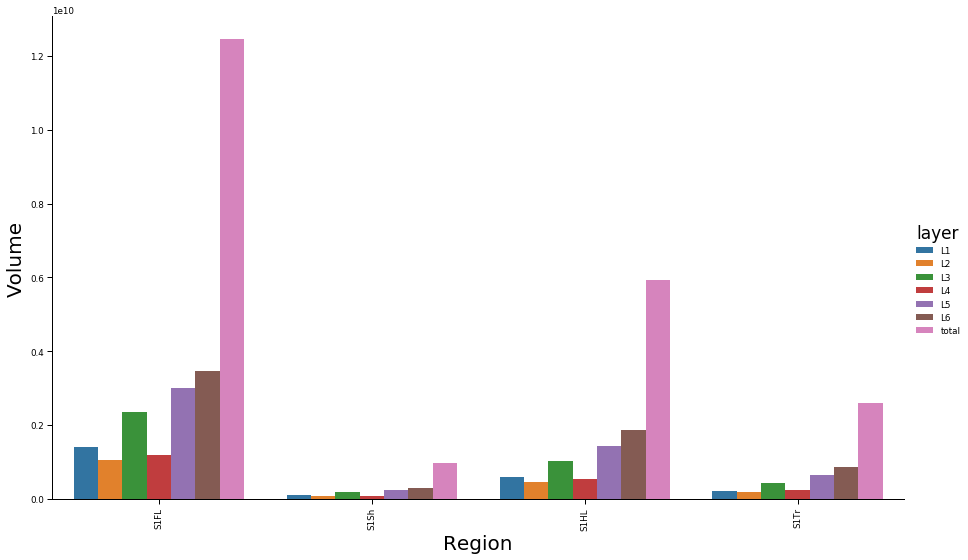

In [13]:
report_volumes = analysis_region_volumes(circuit_model, adapter)

In [14]:
reload(rp)
reporter =\
    rp.CheetahReporter(
        path_output_folder=os.path.join(
            spec.path_reports, "analyses"))
reporter.post(report_volumes)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-09 12:25:23>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x7ffea1ce02b0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-09 12:25:23>                                                      
Post report volume at
	 /gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/volume/20200309/123141

/gpfs/bbp.cscs.ch/h

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/volume/20200309/123141'

### Layer Thickness

Layer thickness is tricky to define for an atlas based circuit.
We expect that for a given sub-region a sample of layer thicknesses can be drawn.
Our next analysis uses this technique and plots the distribution of drawn samples
for each sub-region.

In [70]:
def measurement_thickness(
        adapter, circuit_model,
        region=None,
        **kwargs):
    """
    Measure layer thickness in the given region.
    """
    wide = adapter.get_layer_thickness_values(circuit_model, region=region)
    wide.columns.name = "layer"
    return\
        pd.concat([wide.iloc[i] for i in range(wide.shape[0])])\
          .rename("thickness")

In [96]:
phenomenon["thickness"] =\
    Phenomenon(
        "Thickness",
        description="Thickness of layers.",
        group="Composition")

analysis_layer_thickness =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["thickness"],
        introduction="""
        Thickness of layers measured in each region modeled in the circuit.
        """,
        methods="""
        Thickness of layers were measured as the shortest top-bottom line
        passing through each voxel in the voxelized space.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions),
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_measurement=measurement_thickness,
        measurement_collection=measurement.collection.series_type,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="thickness",
                     ylabel="Thickness",
                     gvar="layer"),
        report=CircuitAnalysisReport)





  0%|          | 0/4 [00:00<?, ?it/s]



 25%|██▌       | 1/4 [00:24<01:12, 24.28s/it]



 50%|█████     | 2/4 [00:50<00:49, 24.99s/it]



 75%|███████▌  | 3/4 [01:13<00:24, 24.37s/it]



100%|██████████| 4/4 [01:37<00:00, 24.27s/it]


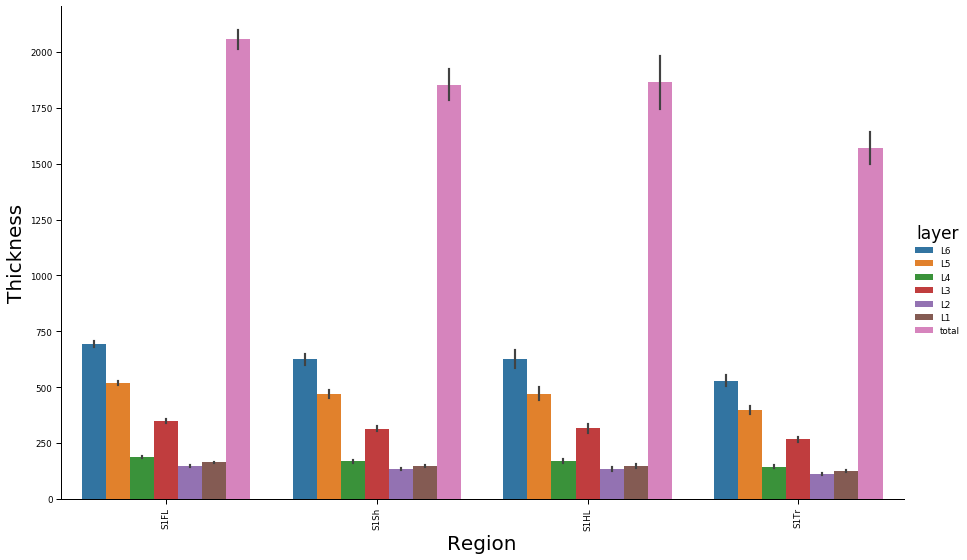

In [97]:
report_thickness =\
    analysis_layer_thickness(circuit_model, adapter)

In [98]:
reporter.post(report_thickness)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x19b46dcd0>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-06 15:56:00>                                                      
Post report thickness at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visoo

'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/thickness/20200306/175218'

## Cell Distribution

In this section we study the distribution of cells over the physical geometry
of the circuit.


In [13]:
def random_position(
        adapter, circuit_model,
        **query):
    """
    Random position in circuit region specified by `query`.
    """
    spatial_query = terminology.circuit.get_spatial_query(query)
    return adapter.random_position(circuit_model, **spatial_query)
    
def random_box(
        adapter, circuit_model, 
        size_roi=100., **query):
    """
    Random cuboid in circuit region specified by `query`.
    """
    position = random_position(adapter, circuit_model, **query)
    return Cuboid(position - size_roi, position + size_roi)\
        if position is not None else None

def measurement_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    return adapter.get_cells(circuit_model, roi=box).shape[0]\
        if box is not None else 0.

### Cell Count

Circuit regions and layers are not the same size, and contain different densities
of cells.

In [14]:
phenomenon["cell_count"] =\
    Phenomenon("Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
analysis_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_count_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_count",
                     ylabel="Cell Count",
                     gvar="layer"),
        report=CircuitAnalysisReport)
                                       

  0%|          | 0/480 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (23956, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed40cb3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  0%|          | 1/480 [00:43<5:46:50, 43.45s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d320>}



  0%|          | 2/480 [00:43<4:02:53, 30.49s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d160>}



  1%|          | 3/480 [00:43<2:50:19, 21.42s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6d8>}



  1%|          | 4/480 [00:44<1:59:36, 15.08s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a9e8>}



  1%|          | 5/480 [00:44<1:24:16, 10.65s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a940>}



  1%|▏         | 6/480 [00:44<59:30,  7.53s/it]  

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}



  1%|▏         | 7/480 [00:45<42:14,  5.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acf8>}



  2%|▏         | 8/480 [00:45<30:13,  3.84s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  2%|▏         | 9/480 [00:45<21:44,  2.77s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  2%|▏         | 10/480 [00:45<15:52,  2.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a7f0>}



  2%|▏         | 11/480 [00:46<11:42,  1.50s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab38>}



  2%|▎         | 12/480 [00:46<08:47,  1.13s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323320>}



  3%|▎         | 13/480 [00:46<06:50,  1.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323240>}



  3%|▎         | 14/480 [00:47<05:26,  1.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



  3%|▎         | 15/480 [00:47<04:25,  1.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323b00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323b00>}



  3%|▎         | 16/480 [00:47<03:43,  2.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



  4%|▎         | 17/480 [00:47<03:15,  2.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323fd0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323fd0>}



  4%|▍         | 18/480 [00:48<02:53,  2.67it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



  4%|▍         | 19/480 [00:48<02:39,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323198>}



  4%|▍         | 20/480 [00:48<02:31,  3.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (18138, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  4%|▍         | 21/480 [01:00<28:19,  3.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acf8>}



  5%|▍         | 22/480 [01:00<20:23,  2.67s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a898>}



  5%|▍         | 23/480 [01:00<14:57,  1.96s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a5f8>}



  5%|▌         | 24/480 [01:01<11:02,  1.45s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  5%|▌         | 25/480 [01:01<08:24,  1.11s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  5%|▌         | 26/480 [01:01<06:34,  1.15it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a978>}



  6%|▌         | 27/480 [01:02<05:11,  1.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}



  6%|▌         | 28/480 [01:02<04:20,  1.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a128>}



  6%|▌         | 29/480 [01:02<03:43,  2.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430af98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430af98>}



  6%|▋         | 30/480 [01:02<03:13,  2.33it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a048>}



  6%|▋         | 31/480 [01:03<02:52,  2.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a438>}



  7%|▋         | 32/480 [01:03<02:37,  2.85it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323048>}



  7%|▋         | 33/480 [01:03<02:26,  3.04it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430abe0>}



  7%|▋         | 34/480 [01:04<02:19,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



  7%|▋         | 35/480 [01:04<02:13,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed408d080>}



  8%|▊         | 36/480 [01:04<02:08,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a438>}



  8%|▊         | 37/480 [01:04<02:10,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a518>}



  8%|▊         | 38/480 [01:05<02:05,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}



  8%|▊         | 39/480 [01:05<02:04,  3.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0af28>}



  8%|▊         | 40/480 [01:05<02:03,  3.57it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (40583, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

  9%|▊         | 41/480 [01:19<31:09,  4.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743234a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743234a8>}



  9%|▉         | 42/480 [01:19<22:20,  3.06s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}



  9%|▉         | 43/480 [01:19<16:17,  2.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323278>}



  9%|▉         | 44/480 [01:20<12:01,  1.65s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}



  9%|▉         | 45/480 [01:20<09:01,  1.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 10%|▉         | 46/480 [01:20<06:54,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



 10%|▉         | 47/480 [01:20<05:27,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab70>}



 10%|█         | 48/480 [01:21<04:29,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a828>}



 10%|█         | 49/480 [01:21<03:44,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430acc0>}



 10%|█         | 50/480 [01:21<03:13,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323d68>}



 11%|█         | 51/480 [01:22<02:49,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a400>}



 11%|█         | 52/480 [01:22<02:35,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323780>}



 11%|█         | 53/480 [01:22<02:27,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323160>}



 11%|█▏        | 54/480 [01:23<02:20,  3.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a828>}



 11%|█▏        | 55/480 [01:23<02:13,  3.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}



 12%|█▏        | 56/480 [01:23<02:13,  3.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0a240>}



 12%|█▏        | 57/480 [01:23<02:08,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65550>}



 12%|█▏        | 58/480 [01:24<02:05,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0acc0>}



 12%|█▏        | 59/480 [01:24<02:01,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeea70b6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeea70b6d8>}



 12%|█▎        | 60/480 [01:24<02:00,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (20429, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 13%|█▎        | 61/480 [01:36<26:41,  3.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 62/480 [01:37<19:14,  2.76s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 63/480 [01:37<14:02,  2.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 13%|█▎        | 64/480 [01:37<10:24,  1.50s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▎        | 65/480 [01:37<07:53,  1.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▍        | 66/480 [01:38<06:05,  1.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a4a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a4a8>}



 14%|█▍        | 67/480 [01:38<04:49,  1.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65ba8>}



 14%|█▍        | 68/480 [01:38<03:55,  1.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323be0>}



 14%|█▍        | 69/480 [01:39<03:19,  2.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65390>}



 15%|█▍        | 70/480 [01:39<02:56,  2.33it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}



 15%|█▍        | 71/480 [01:39<02:37,  2.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430aa20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430aa20>}



 15%|█▌        | 72/480 [01:39<02:25,  2.80it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743235c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743235c0>}



 15%|█▌        | 73/480 [01:40<02:15,  3.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 15%|█▌        | 74/480 [01:40<02:08,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed3c0abe0>}



 16%|█▌        | 75/480 [01:40<02:03,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}



 16%|█▌        | 76/480 [01:41<02:03,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652e8>}



 16%|█▌        | 77/480 [01:41<01:58,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65b70>}



 16%|█▋        | 78/480 [01:41<01:55,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e652b0>}



 16%|█▋        | 79/480 [01:41<01:54,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65eb8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65eb8>}



 17%|█▋        | 80/480 [01:42<01:52,  3.57it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (51522, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 17%|█▋        | 81/480 [01:56<29:28,  4.43s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



 17%|█▋        | 82/480 [01:56<21:07,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}



 17%|█▋        | 83/480 [01:56<15:20,  2.32s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323e48>}



 18%|█▊        | 84/480 [01:57<11:15,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeb109dcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffeb109dcc0>}



 18%|█▊        | 85/480 [01:57<08:27,  1.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc88>}



 18%|█▊        | 86/480 [01:57<06:29,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b978>}



 18%|█▊        | 87/480 [01:58<05:08,  1.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}



 18%|█▊        | 88/480 [01:58<04:06,  1.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323da0>}



 19%|█▊        | 89/480 [01:58<03:28,  1.87it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743231d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743231d0>}



 19%|█▉        | 90/480 [01:58<02:57,  2.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b940>}



 19%|█▉        | 91/480 [01:59<02:37,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be48>}



 19%|█▉        | 92/480 [01:59<02:23,  2.71it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba90>}



 19%|█▉        | 93/480 [01:59<02:16,  2.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}



 20%|█▉        | 94/480 [02:00<02:05,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b5c0>}



 20%|█▉        | 95/480 [02:00<02:01,  3.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b208>}



 20%|██        | 96/480 [02:00<01:59,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b358>}



 20%|██        | 97/480 [02:00<01:54,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}



 20%|██        | 98/480 [02:01<01:52,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b668>}



 21%|██        | 99/480 [02:01<01:50,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b390>}



 21%|██        | 100/480 [02:01<01:48,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1FL', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (59575, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 21%|██        | 101/480 [02:20<36:45,  5.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8978>}



 21%|██▏       | 102/480 [02:20<26:11,  4.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8be0>}



 21%|██▏       | 103/480 [02:21<18:48,  2.99s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8ac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8ac8>}



 22%|██▏       | 104/480 [02:21<13:40,  2.18s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}



 22%|██▏       | 105/480 [02:21<10:04,  1.61s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8080>}



 22%|██▏       | 106/480 [02:21<07:36,  1.22s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65be0>}



 22%|██▏       | 107/480 [02:22<05:52,  1.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65940>}



 22%|██▎       | 108/480 [02:22<04:34,  1.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 23%|██▎       | 109/480 [02:22<03:46,  1.64it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65278>}



 23%|██▎       | 110/480 [02:23<03:11,  1.93it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}



 23%|██▎       | 111/480 [02:23<02:43,  2.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8518>}



 23%|██▎       | 112/480 [02:23<02:29,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8668>}



 24%|██▎       | 113/480 [02:23<02:13,  2.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 24%|██▍       | 114/480 [02:24<02:07,  2.86it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb87b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb87b8>}



 24%|██▍       | 115/480 [02:24<01:58,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323358>}



 24%|██▍       | 116/480 [02:24<01:56,  3.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743237f0>}



 24%|██▍       | 117/480 [02:25<01:52,  3.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323898>}



 25%|██▍       | 118/480 [02:25<01:47,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe74323208>}



 25%|██▍       | 119/480 [02:25<01:50,  3.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8a58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8a58>}



 25%|██▌       | 120/480 [02:25<01:46,  3.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1793, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 25%|██▌       | 121/480 [02:35<18:47,  3.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b7f0>}



 25%|██▌       | 122/480 [02:36<13:35,  2.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}



 26%|██▌       | 123/480 [02:36<10:01,  1.69s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b6a0>}



 26%|██▌       | 124/480 [02:36<07:28,  1.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e650f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e650f0>}



 26%|██▌       | 125/480 [02:36<05:43,  1.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b748>}



 26%|██▋       | 126/480 [02:37<04:27,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8748>}



 26%|██▋       | 127/480 [02:37<03:36,  1.63it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}



 27%|██▋       | 128/480 [02:37<02:58,  1.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65a20>}



 27%|██▋       | 129/480 [02:37<02:32,  2.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 27%|██▋       | 130/480 [02:38<02:19,  2.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8dd8>}



 27%|██▋       | 131/480 [02:38<02:07,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8160>}



 28%|██▊       | 132/480 [02:38<01:57,  2.96it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65588>}



 28%|██▊       | 133/480 [02:39<01:51,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 28%|██▊       | 134/480 [02:39<01:44,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffed9e65080>}



 28%|██▊       | 135/480 [02:39<01:42,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}



 28%|██▊       | 136/480 [02:39<01:38,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}



 29%|██▊       | 137/480 [02:40<01:40,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435bc50>}



 29%|██▉       | 138/480 [02:40<01:42,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036550>}



 29%|██▉       | 139/480 [02:40<01:38,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0362e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0362e8>}



 29%|██▉       | 140/480 [02:41<01:37,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1325, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 29%|██▉       | 141/480 [02:50<17:51,  3.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b198>}



 30%|██▉       | 142/480 [02:51<12:55,  2.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435be10>}



 30%|██▉       | 143/480 [02:51<09:31,  1.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036080>}



 30%|███       | 144/480 [02:51<07:05,  1.27s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036320>}



 30%|███       | 145/480 [02:52<05:28,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}



 30%|███       | 146/480 [02:52<04:15,  1.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 147/480 [02:52<03:29,  1.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 148/480 [02:52<02:56,  1.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███       | 149/480 [02:53<02:32,  2.17it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036ba8>}



 31%|███▏      | 150/480 [02:53<02:13,  2.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0364a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c0364a8>}



 31%|███▏      | 151/480 [02:53<02:00,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c88>}



 32%|███▏      | 152/480 [02:54<01:50,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}



 32%|███▏      | 153/480 [02:54<01:45,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036d68>}



 32%|███▏      | 154/480 [02:54<01:39,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}



 32%|███▏      | 155/480 [02:54<01:35,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036b70>}



 32%|███▎      | 156/480 [02:55<01:37,  3.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}



 33%|███▎      | 157/480 [02:55<01:34,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036a90>}



 33%|███▎      | 158/480 [02:55<01:34,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036128>}



 33%|███▎      | 159/480 [02:56<01:31,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036e80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036e80>}



 33%|███▎      | 160/480 [02:56<01:34,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3018, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 34%|███▎      | 161/480 [03:06<16:58,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 34%|███▍      | 162/480 [03:06<12:18,  2.32s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 34%|███▍      | 163/480 [03:06<09:04,  1.72s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036470>}



 34%|███▍      | 164/480 [03:07<06:45,  1.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435ba20>}



 34%|███▍      | 165/480 [03:07<05:09,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}



 35%|███▍      | 166/480 [03:07<04:00,  1.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}



 35%|███▍      | 167/480 [03:08<03:16,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe80>}



 35%|███▌      | 168/480 [03:08<02:42,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfdd8>}



 35%|███▌      | 169/480 [03:08<02:19,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfef0>}



 35%|███▌      | 170/480 [03:08<02:06,  2.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b780>}



 36%|███▌      | 171/480 [03:09<01:54,  2.70it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036cf8>}



 36%|███▌      | 172/480 [03:09<01:47,  2.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ab00>}



 36%|███▌      | 173/480 [03:09<01:39,  3.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe8435b0f0>}



 36%|███▋      | 174/480 [03:10<01:37,  3.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb70>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb70>}



 36%|███▋      | 175/480 [03:10<01:32,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}



 37%|███▋      | 176/480 [03:10<01:32,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfb00>}



 37%|███▋      | 177/480 [03:10<01:31,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf550>}



 37%|███▋      | 178/480 [03:11<01:28,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}



 37%|███▋      | 179/480 [03:11<01:28,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfe48>}



 38%|███▊      | 180/480 [03:11<01:28,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (1547, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 38%|███▊      | 181/480 [03:21<15:49,  3.18s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfc50>}



 38%|███▊      | 182/480 [03:21<11:26,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf748>}



 38%|███▊      | 183/480 [03:22<08:23,  1.70s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf2b0>}



 38%|███▊      | 184/480 [03:22<06:15,  1.27s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▊      | 185/480 [03:22<04:48,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▉      | 186/480 [03:23<03:46,  1.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf470>}



 39%|███▉      | 187/480 [03:23<03:03,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 39%|███▉      | 188/480 [03:23<02:33,  1.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 39%|███▉      | 189/480 [03:23<02:11,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e160>}



 40%|███▉      | 190/480 [03:24<01:56,  2.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bfa90>}



 40%|███▉      | 191/480 [03:24<01:45,  2.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf6a0>}



 40%|████      | 192/480 [03:24<01:39,  2.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf668>}



 40%|████      | 193/480 [03:25<01:32,  3.10it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}



 40%|████      | 194/480 [03:25<01:28,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c7bf588>}



 41%|████      | 195/480 [03:25<01:26,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}



 41%|████      | 196/480 [03:25<01:24,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}



 41%|████      | 197/480 [03:26<01:22,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e6d8>}



 41%|████▏     | 198/480 [03:26<01:21,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e240>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e240>}



 41%|████▏     | 199/480 [03:26<01:20,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}



 42%|████▏     | 200/480 [03:27<01:19,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4035, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036c50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 42%|████▏     | 201/480 [03:37<14:54,  3.21s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e630>}



 42%|████▏     | 202/480 [03:37<10:47,  2.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}



 42%|████▏     | 203/480 [03:37<07:54,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eef0>}



 42%|████▎     | 204/480 [03:37<05:55,  1.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef60>}



 43%|████▎     | 205/480 [03:38<04:31,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed30>}



 43%|████▎     | 206/480 [03:38<03:31,  1.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e978>}



 43%|████▎     | 207/480 [03:38<02:50,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 43%|████▎     | 208/480 [03:39<02:21,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 44%|████▎     | 209/480 [03:39<02:01,  2.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 44%|████▍     | 210/480 [03:39<01:47,  2.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e780>}



 44%|████▍     | 211/480 [03:39<01:37,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e940>}



 44%|████▍     | 212/480 [03:40<01:30,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}



 44%|████▍     | 213/480 [03:40<01:25,  3.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ed68>}



 45%|████▍     | 214/480 [03:40<01:21,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 45%|████▍     | 215/480 [03:41<01:21,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 45%|████▌     | 216/480 [03:41<01:17,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eeb8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0eeb8>}



 45%|████▌     | 217/480 [03:41<01:15,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d358>}



 45%|████▌     | 218/480 [03:41<01:15,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2e8>}



 46%|████▌     | 219/480 [03:42<01:14,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d630>}



 46%|████▌     | 220/480 [03:42<01:12,  3.58it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Sh', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4965, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 46%|████▌     | 221/480 [03:52<14:01,  3.25s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0ef28>}



 46%|████▋     | 222/480 [03:52<10:07,  2.35s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c036518>}



 46%|████▋     | 223/480 [03:53<07:24,  1.73s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}



 47%|████▋     | 224/480 [03:53<05:31,  1.29s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d710>}



 47%|████▋     | 225/480 [03:53<04:12,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}



 47%|████▋     | 226/480 [03:53<03:16,  1.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33db00>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33db00>}



 47%|████▋     | 227/480 [03:54<02:37,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}



 48%|████▊     | 228/480 [03:54<02:10,  1.94it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d128>}



 48%|████▊     | 229/480 [03:54<01:51,  2.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d208>}



 48%|████▊     | 230/480 [03:55<01:37,  2.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}



 48%|████▊     | 231/480 [03:55<01:28,  2.81it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d898>}



 48%|████▊     | 232/480 [03:55<01:21,  3.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d470>}



 49%|████▊     | 233/480 [03:55<01:16,  3.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 49%|████▉     | 234/480 [03:56<01:14,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 49%|████▉     | 235/480 [03:56<01:11,  3.42it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}



 49%|████▉     | 236/480 [03:56<01:10,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dba8>}



 49%|████▉     | 237/480 [03:56<01:08,  3.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 50%|████▉     | 238/480 [03:57<01:07,  3.61it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d550>}



 50%|████▉     | 239/480 [03:57<01:07,  3.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 50%|█████     | 240/480 [03:57<01:05,  3.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (10085, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ac50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 50%|█████     | 241/480 [04:12<18:07,  4.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb82e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb82e8>}



 50%|█████     | 242/480 [04:12<13:04,  3.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8e10>}



 51%|█████     | 243/480 [04:13<09:38,  2.44s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33df60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33df60>}



 51%|█████     | 244/480 [04:13<07:02,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd68>}



 51%|█████     | 245/480 [04:13<05:13,  1.34s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d668>}



 51%|█████▏    | 246/480 [04:13<04:00,  1.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6da0>}



 51%|█████▏    | 247/480 [04:14<03:06,  1.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d940>}



 52%|█████▏    | 248/480 [04:14<02:29,  1.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8cf8>}



 52%|█████▏    | 249/480 [04:14<02:03,  1.87it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dda0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dda0>}



 52%|█████▏    | 250/480 [04:15<01:44,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}



 52%|█████▏    | 251/480 [04:15<01:32,  2.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7dbb8710>}



 52%|█████▎    | 252/480 [04:15<01:22,  2.76it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6e48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6e48>}



 53%|█████▎    | 253/480 [04:15<01:16,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ba8>}



 53%|█████▎    | 254/480 [04:16<01:11,  3.17it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6828>}



 53%|█████▎    | 255/480 [04:16<01:08,  3.31it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 53%|█████▎    | 256/480 [04:16<01:04,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6278>}



 54%|█████▎    | 257/480 [04:16<01:05,  3.42it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6780>}



 54%|█████▍    | 258/480 [04:17<01:04,  3.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6358>}



 54%|█████▍    | 259/480 [04:17<01:04,  3.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a60f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a60f0>}



 54%|█████▍    | 260/480 [04:17<01:02,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (7674, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33dd30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 54%|█████▍    | 261/480 [04:28<12:20,  3.38s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 55%|█████▍    | 262/480 [04:28<08:52,  2.44s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▍    | 263/480 [04:28<06:28,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6a90>}



 55%|█████▌    | 264/480 [04:29<04:48,  1.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▌    | 265/480 [04:29<03:40,  1.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 55%|█████▌    | 266/480 [04:29<02:52,  1.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6d68>}



 56%|█████▌    | 267/480 [04:30<02:16,  1.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7198>}



 56%|█████▌    | 268/480 [04:30<01:52,  1.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 56%|█████▌    | 269/480 [04:30<01:36,  2.18it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 56%|█████▋    | 270/480 [04:30<01:24,  2.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 56%|█████▋    | 271/480 [04:31<01:17,  2.68it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 57%|█████▋    | 272/480 [04:31<01:10,  2.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}



 57%|█████▋    | 273/480 [04:31<01:08,  3.04it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6080>}



 57%|█████▋    | 274/480 [04:32<01:05,  3.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a65c0>}



 57%|█████▋    | 275/480 [04:32<01:02,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa76d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa76d8>}



 57%|█████▊    | 276/480 [04:32<01:00,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa71d0>}



 58%|█████▊    | 277/480 [04:32<00:59,  3.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 278/480 [04:33<00:59,  3.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 279/480 [04:33<00:59,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7780>}



 58%|█████▊    | 280/480 [04:33<00:57,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (17749, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33da58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 59%|█████▊    | 281/480 [04:44<11:40,  3.52s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa75f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa75f8>}



 59%|█████▉    | 282/480 [04:45<08:23,  2.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7400>}



 59%|█████▉    | 283/480 [04:45<06:06,  1.86s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 59%|█████▉    | 284/480 [04:45<04:33,  1.40s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 59%|█████▉    | 285/480 [04:45<03:27,  1.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7390>}



 60%|█████▉    | 286/480 [04:46<02:40,  1.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7358>}



 60%|█████▉    | 287/480 [04:46<02:08,  1.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}



 60%|██████    | 288/480 [04:46<01:46,  1.81it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cc0>}



 60%|██████    | 289/480 [04:47<01:29,  2.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7ef0>}



 60%|██████    | 290/480 [04:47<01:18,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 291/480 [04:47<01:12,  2.62it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 292/480 [04:47<01:06,  2.82it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7b38>}



 61%|██████    | 293/480 [04:48<01:01,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e860>}



 61%|██████▏   | 294/480 [04:48<00:57,  3.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e668>}



 61%|██████▏   | 295/480 [04:48<00:57,  3.22it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7828>}



 62%|██████▏   | 296/480 [04:49<00:54,  3.35it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7cf8>}



 62%|██████▏   | 297/480 [04:49<00:52,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d4a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d4a8>}



 62%|██████▏   | 298/480 [04:49<00:53,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}



 62%|██████▏   | 299/480 [04:49<00:53,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d518>}



 62%|██████▎   | 300/480 [04:50<00:53,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (9335, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 63%|██████▎   | 301/480 [05:01<10:34,  3.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cc0e3c8>}



 63%|██████▎   | 302/480 [05:01<07:36,  2.57s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6d8>}



 63%|██████▎   | 303/480 [05:01<05:32,  1.88s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3de48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3de48>}



 63%|██████▎   | 304/480 [05:02<04:06,  1.40s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▎   | 305/480 [05:02<03:06,  1.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 306/480 [05:02<02:25,  1.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 307/480 [05:03<01:57,  1.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 308/480 [05:03<01:36,  1.78it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d080>}



 64%|██████▍   | 309/480 [05:03<01:21,  2.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}



 65%|██████▍   | 310/480 [05:03<01:10,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}



 65%|██████▍   | 311/480 [05:04<01:03,  2.68it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7fd0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cfa7fd0>}



 65%|██████▌   | 312/480 [05:04<00:58,  2.89it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 65%|██████▌   | 313/480 [05:04<00:54,  3.08it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d358>}



 65%|██████▌   | 314/480 [05:05<00:51,  3.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 66%|██████▌   | 315/480 [05:05<00:51,  3.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc50>}



 66%|██████▌   | 316/480 [05:05<00:48,  3.36it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dba8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dba8>}



 66%|██████▌   | 317/480 [05:05<00:47,  3.45it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3da58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3da58>}



 66%|██████▋   | 318/480 [05:06<00:46,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d2b0>}



 66%|██████▋   | 319/480 [05:06<00:45,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d550>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d550>}



 67%|██████▋   | 320/480 [05:06<00:45,  3.54it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (24715, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a62b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 67%|██████▋   | 321/480 [05:19<10:16,  3.88s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6ef0>}



 67%|██████▋   | 322/480 [05:19<07:23,  2.80s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430a6a0>}



 67%|██████▋   | 323/480 [05:19<05:22,  2.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d400>}



 68%|██████▊   | 324/480 [05:19<03:56,  1.52s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc18>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3dc18>}



 68%|██████▊   | 325/480 [05:20<02:57,  1.14s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d160>}



 68%|██████▊   | 326/480 [05:20<02:17,  1.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}



 68%|██████▊   | 327/480 [05:20<01:48,  1.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d9b0>}



 68%|██████▊   | 328/480 [05:21<01:28,  1.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d6a0>}



 69%|██████▊   | 329/480 [05:21<01:14,  2.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d390>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d390>}



 69%|██████▉   | 330/480 [05:21<01:05,  2.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d5f8>}



 69%|██████▉   | 331/480 [05:21<00:57,  2.59it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d198>}



 69%|██████▉   | 332/480 [05:22<00:53,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cd3d898>}



 69%|██████▉   | 333/480 [05:22<00:49,  2.97it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4be0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4be0>}



 70%|██████▉   | 334/480 [05:22<00:46,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}



 70%|██████▉   | 335/480 [05:23<00:44,  3.27it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 70%|███████   | 336/480 [05:23<00:43,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4630>}



 70%|███████   | 337/480 [05:23<00:43,  3.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4278>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4278>}



 70%|███████   | 338/480 [05:23<00:42,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}



 71%|███████   | 339/480 [05:24<00:41,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 71%|███████   | 340/480 [05:24<00:40,  3.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1HL', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (32299, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4748>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 71%|███████   | 341/480 [05:37<09:43,  4.20s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf45f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf45f8>}



 71%|███████▏  | 342/480 [05:38<06:58,  3.03s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d2b0>}



 71%|███████▏  | 343/480 [05:38<05:02,  2.21s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 72%|███████▏  | 344/480 [05:38<03:41,  1.63s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a63c8>}



 72%|███████▏  | 345/480 [05:39<02:46,  1.23s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}



 72%|███████▏  | 346/480 [05:39<02:07,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4978>}



 72%|███████▏  | 347/480 [05:39<01:39,  1.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe1d0>}



 72%|███████▎  | 348/480 [05:39<01:20,  1.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 73%|███████▎  | 349/480 [05:40<01:07,  1.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe320>}



 73%|███████▎  | 350/480 [05:40<00:57,  2.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a68d0>}



 73%|███████▎  | 351/480 [05:40<00:50,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743232e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe743232e8>}



 73%|███████▎  | 352/480 [05:41<00:46,  2.73it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4898>}



 74%|███████▎  | 353/480 [05:41<00:43,  2.95it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4da0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4da0>}



 74%|███████▍  | 354/480 [05:41<00:40,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf46a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf46a0>}



 74%|███████▍  | 355/480 [05:41<00:40,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}



 74%|███████▍  | 356/480 [05:42<00:37,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}



 74%|███████▍  | 357/480 [05:42<00:36,  3.34it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}



 75%|███████▍  | 358/480 [05:42<00:36,  3.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe160>}



 75%|███████▍  | 359/480 [05:42<00:34,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}



 75%|███████▌  | 360/480 [05:43<00:34,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L1'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3773, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4c88>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 75%|███████▌  | 361/480 [05:53<06:15,  3.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe898>}



 75%|███████▌  | 362/480 [05:53<04:31,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 76%|███████▌  | 363/480 [05:53<03:17,  1.69s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}



 76%|███████▌  | 364/480 [05:53<02:26,  1.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe208>}



 76%|███████▌  | 365/480 [05:54<01:52,  1.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fedd8>}



 76%|███████▋  | 366/480 [05:54<01:27,  1.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe860>}



 76%|███████▋  | 367/480 [05:54<01:10,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feef0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feef0>}



 77%|███████▋  | 368/480 [05:55<00:58,  1.91it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fef60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fef60>}



 77%|███████▋  | 369/480 [05:55<00:49,  2.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe908>}



 77%|███████▋  | 370/480 [05:55<00:43,  2.53it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe940>}



 77%|███████▋  | 371/480 [05:55<00:39,  2.75it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe358>}



 78%|███████▊  | 372/480 [05:56<00:36,  2.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe588>}



 78%|███████▊  | 373/480 [05:56<00:34,  3.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe128>}



 78%|███████▊  | 374/480 [05:56<00:33,  3.12it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe048>}



 78%|███████▊  | 375/480 [05:57<00:31,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}



 78%|███████▊  | 376/480 [05:57<00:31,  3.30it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe5f8>}



 79%|███████▊  | 377/480 [05:57<00:30,  3.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 79%|███████▉  | 378/480 [05:57<00:29,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f160>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f160>}



 79%|███████▉  | 379/480 [05:58<00:28,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 79%|███████▉  | 380/480 [05:58<00:28,  3.50it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L2'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (3151, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2feb38>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 79%|███████▉  | 381/480 [06:12<07:26,  4.51s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4128>}



 80%|███████▉  | 382/480 [06:13<05:21,  3.28s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f358>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f358>}



 80%|███████▉  | 383/480 [06:13<03:55,  2.43s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}



 80%|████████  | 384/480 [06:14<02:54,  1.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f780>}



 80%|████████  | 385/480 [06:14<02:12,  1.39s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 80%|████████  | 386/480 [06:14<01:43,  1.10s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 387/480 [06:15<01:23,  1.11it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 388/480 [06:15<01:09,  1.32it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████  | 389/480 [06:16<00:58,  1.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f1d0>}



 81%|████████▏ | 390/480 [06:16<00:51,  1.74it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}



 81%|████████▏ | 391/480 [06:17<00:47,  1.88it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f6d8>}



 82%|████████▏ | 392/480 [06:17<00:40,  2.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f668>}



 82%|████████▏ | 393/480 [06:17<00:35,  2.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}



 82%|████████▏ | 394/480 [06:17<00:32,  2.66it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa58>}



 82%|████████▏ | 395/480 [06:18<00:29,  2.90it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}



 82%|████████▎ | 396/480 [06:18<00:27,  3.09it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}



 83%|████████▎ | 397/480 [06:18<00:26,  3.19it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fa90>}



 83%|████████▎ | 398/480 [06:19<00:25,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fac8>}



 83%|████████▎ | 399/480 [06:19<00:25,  3.23it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fbe0>}



 83%|████████▎ | 400/480 [06:19<00:23,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L3'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (7591, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 84%|████████▎ | 401/480 [06:30<04:23,  3.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c2fe2e8>}



 84%|████████▍ | 402/480 [06:30<03:08,  2.41s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f198>}



 84%|████████▍ | 403/480 [06:30<02:17,  1.78s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fe48>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fe48>}



 84%|████████▍ | 404/480 [06:30<01:41,  1.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f28>}



 84%|████████▍ | 405/480 [06:31<01:16,  1.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▍ | 406/480 [06:31<00:59,  1.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▍ | 407/480 [06:31<00:47,  1.54it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▌ | 408/480 [06:32<00:39,  1.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7e10>}



 85%|████████▌ | 409/480 [06:32<00:32,  2.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 85%|████████▌ | 410/480 [06:32<00:29,  2.39it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f5f8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24f5f8>}



 86%|████████▌ | 411/480 [06:32<00:26,  2.62it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}



 86%|████████▌ | 412/480 [06:33<00:24,  2.80it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcc0>}



 86%|████████▌ | 413/480 [06:33<00:22,  2.93it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d76a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d76a0>}



 86%|████████▋ | 414/480 [06:33<00:21,  3.02it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 86%|████████▋ | 415/480 [06:34<00:20,  3.14it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 87%|████████▋ | 416/480 [06:34<00:20,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 87%|████████▋ | 417/480 [06:34<00:19,  3.26it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 87%|████████▋ | 418/480 [06:35<00:18,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 87%|████████▋ | 419/480 [06:35<00:17,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7128>}



 88%|████████▊ | 420/480 [06:35<00:17,  3.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L4'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (4153, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/d

 88%|████████▊ | 421/480 [06:45<03:12,  3.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7a90>}



 88%|████████▊ | 422/480 [06:46<02:16,  2.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d70b8>}



 88%|████████▊ | 423/480 [06:46<01:39,  1.74s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d77f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d77f0>}



 88%|████████▊ | 424/480 [06:46<01:12,  1.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}



 89%|████████▊ | 425/480 [06:46<00:54,  1.01it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74a8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74a8>}



 89%|████████▉ | 426/480 [06:47<00:42,  1.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7400>}



 89%|████████▉ | 427/480 [06:47<00:33,  1.60it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d048>}



 89%|████████▉ | 428/480 [06:47<00:27,  1.92it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 89%|████████▉ | 429/480 [06:48<00:23,  2.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 90%|████████▉ | 430/480 [06:48<00:19,  2.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7f60>}



 90%|████████▉ | 431/480 [06:48<00:17,  2.77it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7668>}



 90%|█████████ | 432/480 [06:48<00:16,  2.98it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74e0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d74e0>}



 90%|█████████ | 433/480 [06:49<00:14,  3.16it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7978>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7978>}



 90%|█████████ | 434/480 [06:49<00:13,  3.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7898>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7898>}



 91%|█████████ | 435/480 [06:49<00:13,  3.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 91%|█████████ | 436/480 [06:49<00:12,  3.46it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d630>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d630>}



 91%|█████████ | 437/480 [06:50<00:12,  3.49it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6d8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6d8>}



 91%|█████████▏| 438/480 [06:50<00:11,  3.52it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}



 91%|█████████▏| 439/480 [06:50<00:11,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d780>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d780>}



 92%|█████████▏| 440/480 [06:51<00:11,  3.55it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L5'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (11161, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c24fcf8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 92%|█████████▏| 441/480 [07:01<02:13,  3.42s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07da20>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07da20>}



 92%|█████████▏| 442/480 [07:02<01:33,  2.47s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2b0>}



 92%|█████████▏| 443/480 [07:02<01:07,  1.82s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 92%|█████████▎| 444/480 [07:02<00:49,  1.37s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 445/480 [07:02<00:36,  1.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 446/480 [07:03<00:28,  1.21it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d7f0>}



 93%|█████████▎| 447/480 [07:03<00:21,  1.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d3c8>}



 93%|█████████▎| 448/480 [07:03<00:17,  1.83it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▎| 449/480 [07:04<00:14,  2.13it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▍| 450/480 [07:04<00:12,  2.44it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 94%|█████████▍| 451/480 [07:04<00:10,  2.67it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d9e8>}



 94%|█████████▍| 452/480 [07:04<00:09,  2.84it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d1d0>}



 94%|█████████▍| 453/480 [07:05<00:08,  3.06it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6a0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d6a0>}



 95%|█████████▍| 454/480 [07:05<00:08,  3.20it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d710>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d710>}



 95%|█████████▍| 455/480 [07:05<00:07,  3.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 95%|█████████▌| 456/480 [07:06<00:07,  3.28it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d668>}



 95%|█████████▌| 457/480 [07:06<00:06,  3.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be292e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be292e8>}



 95%|█████████▌| 458/480 [07:06<00:06,  3.51it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}



 96%|█████████▌| 459/480 [07:06<00:06,  3.48it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29438>}



 96%|█████████▌| 460/480 [07:07<00:05,  3.56it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

                Compute visible voxel data for query
                	 {'region': 'S1Tr', 'layer': 'L6'}.
                

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 

            LOGGER.get_source_info(),
            get_voxel_positions for voxel_ids of shape (14803, 3)
            

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7430ad30>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/

 96%|█████████▌| 461/480 [07:19<01:11,  3.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6438>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6438>}



 96%|█████████▋| 462/480 [07:19<00:49,  2.75s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4e80>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4e80>}



 96%|█████████▋| 463/480 [07:19<00:34,  2.05s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07df60>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07df60>}



 97%|█████████▋| 464/480 [07:20<00:24,  1.55s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2e8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07d2e8>}



 97%|█████████▋| 465/480 [07:20<00:18,  1.20s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7d68>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7d68>}



 97%|█████████▋| 466/480 [07:21<00:13,  1.05it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29f28>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29f28>}



 97%|█████████▋| 467/480 [07:21<00:10,  1.24it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}



 98%|█████████▊| 468/480 [07:21<00:08,  1.47it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7dd8>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c1d7dd8>}



 98%|█████████▊| 469/480 [07:22<00:06,  1.65it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6320>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d2a6320>}



 98%|█████████▊| 470/480 [07:22<00:05,  1.85it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07def0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07def0>}



 98%|█████████▊| 471/480 [07:23<00:04,  2.03it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7c07dbe0>}



 98%|█████████▊| 472/480 [07:23<00:03,  2.07it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29c50>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29c50>}



 99%|█████████▊| 473/480 [07:23<00:03,  2.25it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29940>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29940>}



 99%|█████████▉| 474/480 [07:24<00:02,  2.29it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29588>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29588>}



 99%|█████████▉| 475/480 [07:24<00:02,  2.37it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be291d0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be291d0>}



 99%|█████████▉| 476/480 [07:25<00:01,  2.40it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29048>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7be29048>}



 99%|█████████▉| 477/480 [07:25<00:01,  2.38it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d828>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7d33d828>}



100%|█████████▉| 478/480 [07:25<00:00,  2.41it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf4f98>}



100%|█████████▉| 479/480 [07:26<00:00,  2.43it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf42b0>}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'roi': <neuro_dmt.models.bluebrain.circuit.geometry.Cuboid object at 0x7ffe7cbf42b0>}



100%|██████████| 480/480 [07:26<00:00,  2.49it/s]


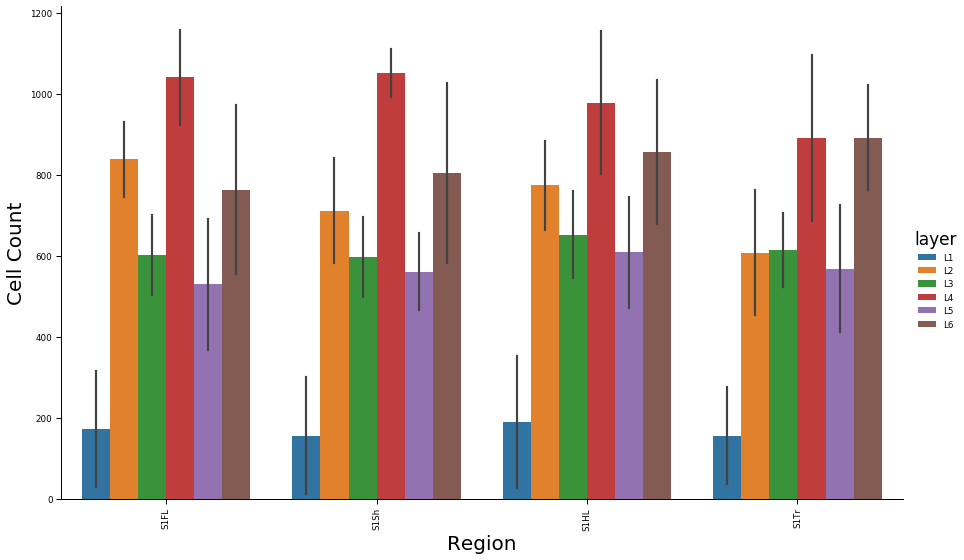

In [15]:
report_cell_count =\
    analysis_cell_count(circuit_model, adapter)

In [16]:
reporter.post(report_cell_count)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x7ffed3c0a668>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-09 13:00:50>                                                      
Post report cell_count_by_region_layer at
	 /gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/cell_count_by_region_la

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/cell_count_by_region_layer/20200309/131030'

### Mtype Cell Counts

We can also count cells in each region, layer by mtype.

In [33]:
phenomenon["mtype_cell_count"] =\
    Phenomenon("Mtype Cell Count", 
               description="Number of cells in the circuit.",
               group="Composition")
    
def measurement_mtype_cell_count_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the number of cells in a spatial location specified by the query.
    """
    box =\
        random_box(adapter, circuit_model, size_roi=size_roi, **query)
    if box is None:
        return pd.Series()
    cells = adapter.get_cells(circuit_model, roi=box)
    return cells.groupby("mtype").agg("size")

def measurement_mtype_cell_count_exhaustive(
        adapter, circuit_model,
        sampling_methodology=None,
        logscale=True,
        **query):
    """
    ...
    """
    cells =\
        adapter.get_cells(circuit_model, **query)
    return\
        cells.groupby("mtype").agg("size").apply(lambda s: np.log10(s + 1))

analysis_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(
            get_regions_and_layers,
            labels=["region", "layer"]),
        sample_measurement=measurement_mtype_cell_count_exhaustive,
        sample_size=1,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="mtype",
            plotter=Bars(xvar="region",
                         xlabel="Region",
                         yvar="mtype_cell_count",
                         ylabel="Log Cell Count",
                         gvar="layer")),
        report=CircuitAnalysisReport)
                                       

  0%|          | 0/24 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L1'}



  4%|▍         | 1/24 [00:01<00:28,  1.25s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L2'}



  8%|▊         | 2/24 [00:03<00:30,  1.41s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L3'}



 12%|█▎        | 3/24 [00:04<00:33,  1.57s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L4'}



 17%|█▋        | 4/24 [00:07<00:34,  1.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L5'}



 21%|██        | 5/24 [00:08<00:33,  1.77s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL', 'layer': 'L6'}



 25%|██▌       | 6/24 [00:11<00:36,  2.04s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L1'}



 29%|██▉       | 7/24 [00:12<00:30,  1.79s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L2'}



 33%|███▎      | 8/24 [00:14<00:26,  1.63s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L3'}



 38%|███▊      | 9/24 [00:15<00:22,  1.51s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L4'}



 42%|████▏     | 10/24 [00:16<00:21,  1.53s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L5'}



 46%|████▌     | 11/24 [00:20<00:26,  2.07s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh', 'layer': 'L6'}



 50%|█████     | 12/24 [00:22<00:25,  2.13s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L1'}



 54%|█████▍    | 13/24 [00:24<00:23,  2.16s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L2'}



 58%|█████▊    | 14/24 [00:27<00:22,  2.22s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L3'}



 62%|██████▎   | 15/24 [00:29<00:19,  2.17s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L4'}



 67%|██████▋   | 16/24 [00:30<00:16,  2.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L5'}



 71%|███████   | 17/24 [00:32<00:13,  1.97s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL', 'layer': 'L6'}



 75%|███████▌  | 18/24 [00:35<00:13,  2.24s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L1'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L1'}



 79%|███████▉  | 19/24 [00:37<00:10,  2.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L2'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L2'}



 83%|████████▎ | 20/24 [00:39<00:09,  2.26s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L3'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L3'}



 88%|████████▊ | 21/24 [00:42<00:06,  2.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L4'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L4'}



 92%|█████████▏| 22/24 [00:44<00:04,  2.38s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L5'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L5'}



 96%|█████████▌| 23/24 [00:47<00:02,  2.37s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr', 'layer': 'L6'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr', 'layer': 'L6'}



100%|██████████| 24/24 [00:49<00:00,  2.21s/it]
/gpfs/bbp.cscs.ch/home/sood/.vmgr_repo/nix36/lib/python3.6/site-packages/seaborn/axisgrid.py:311: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


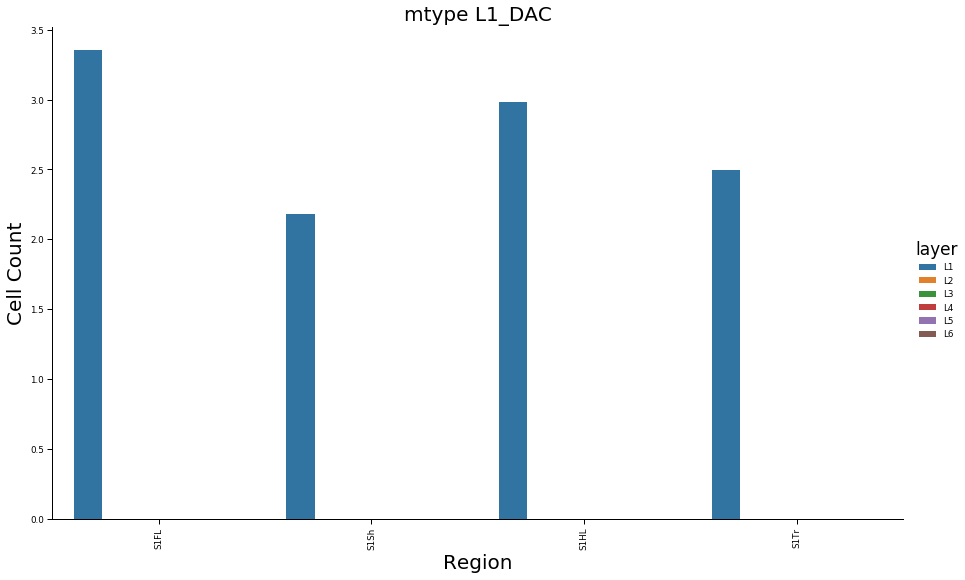

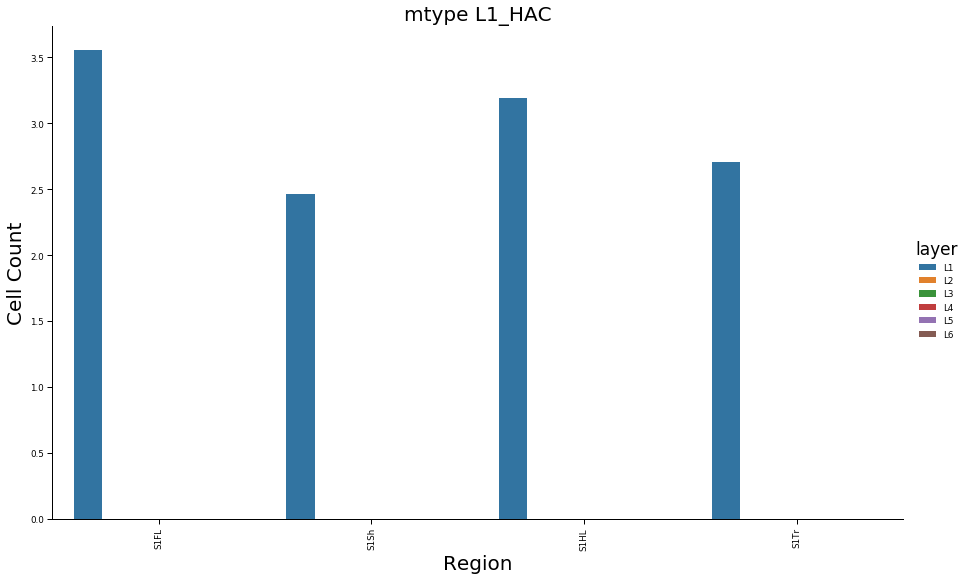

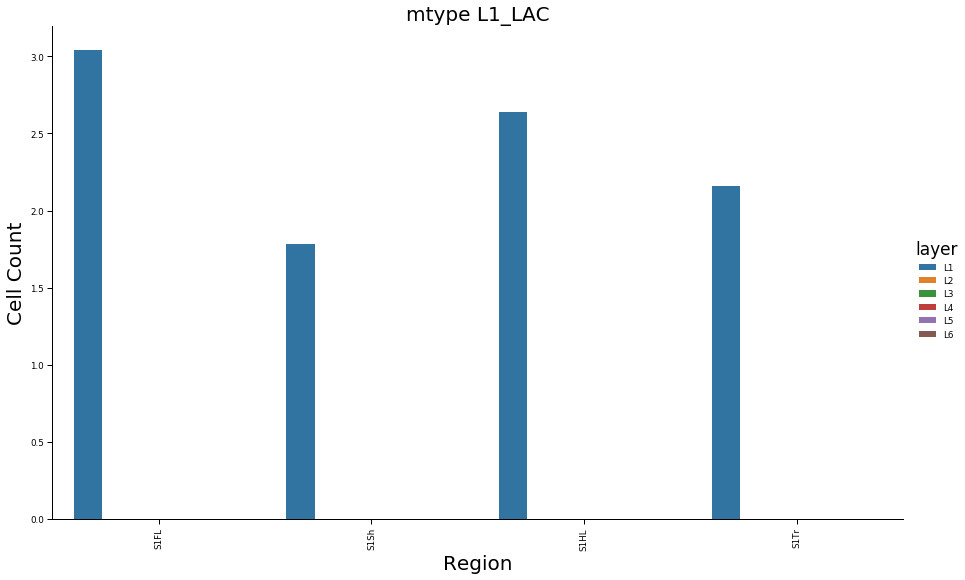

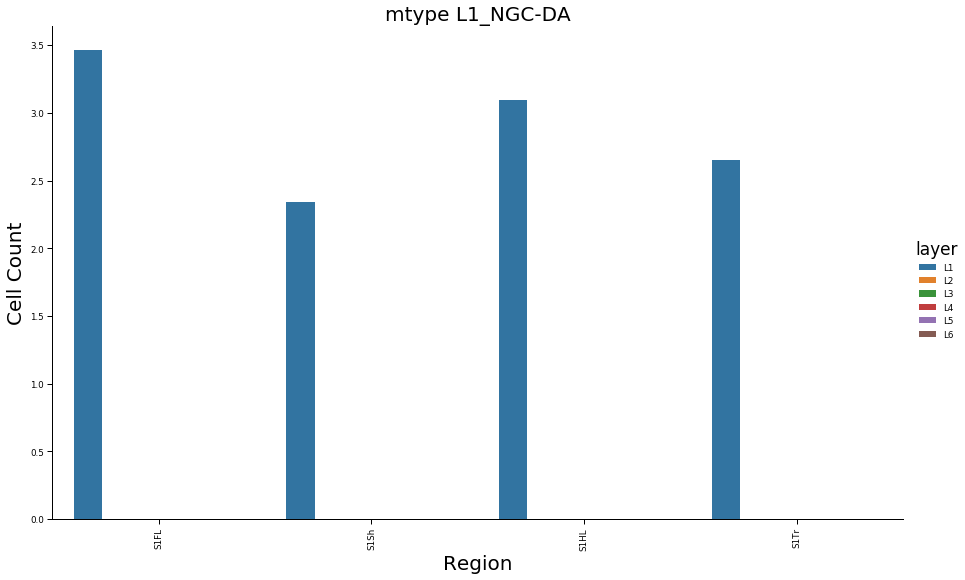

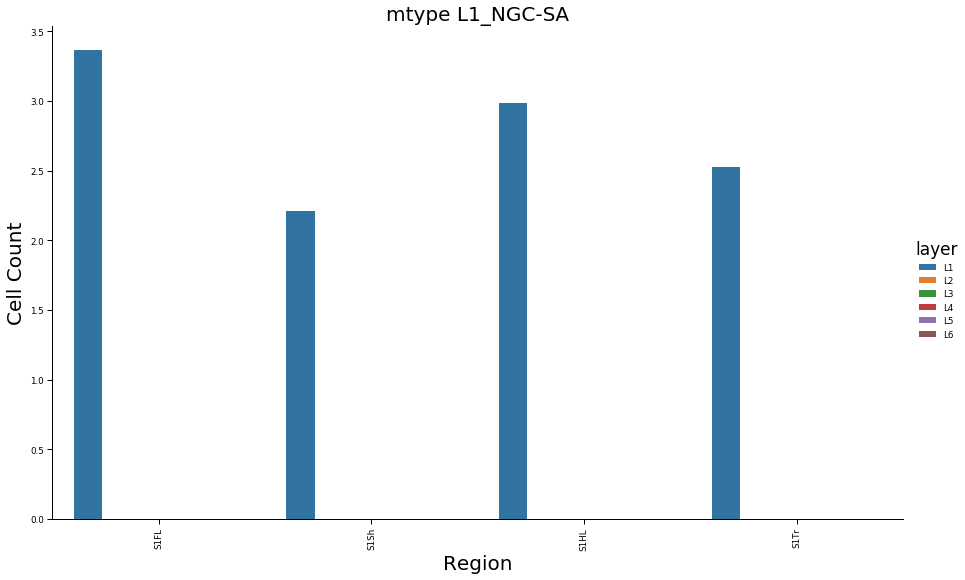

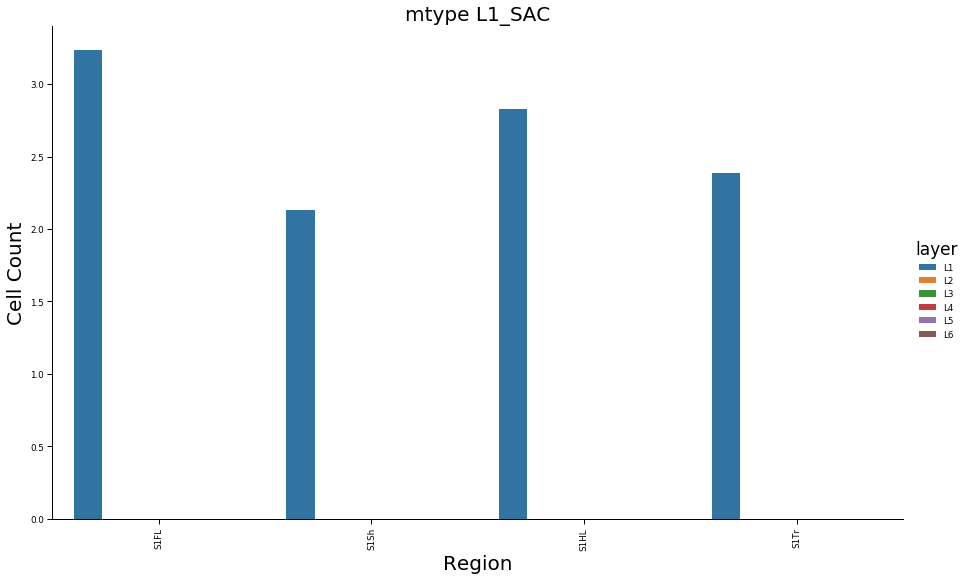

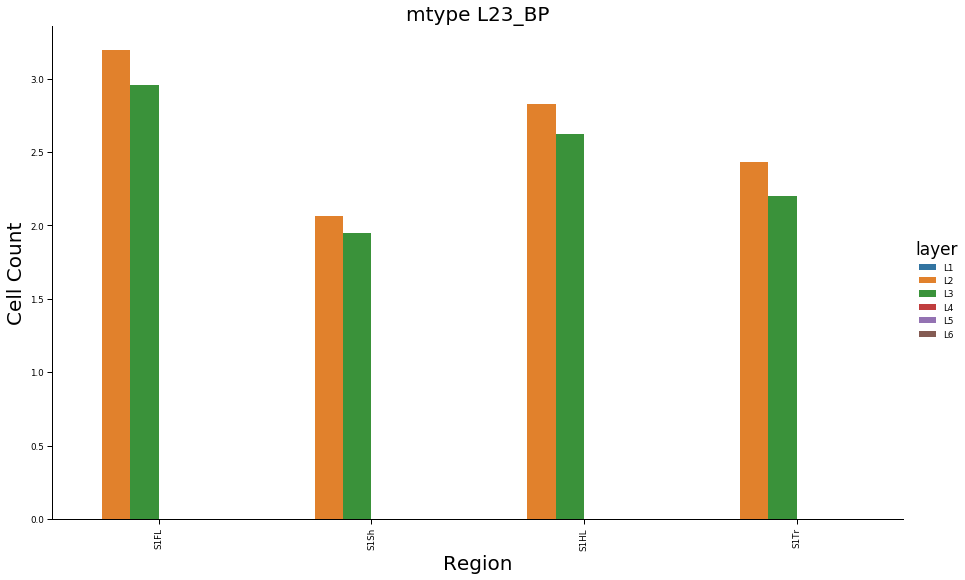

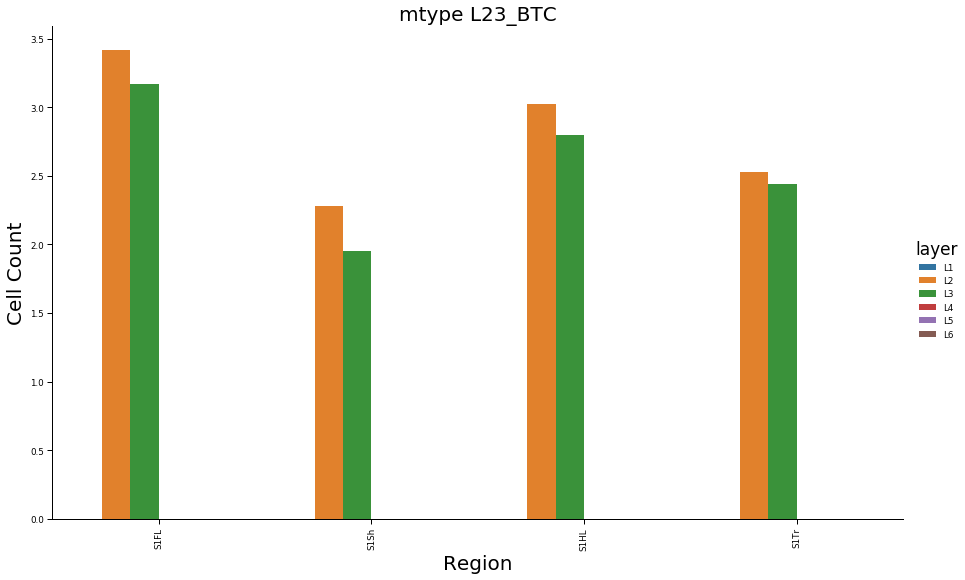

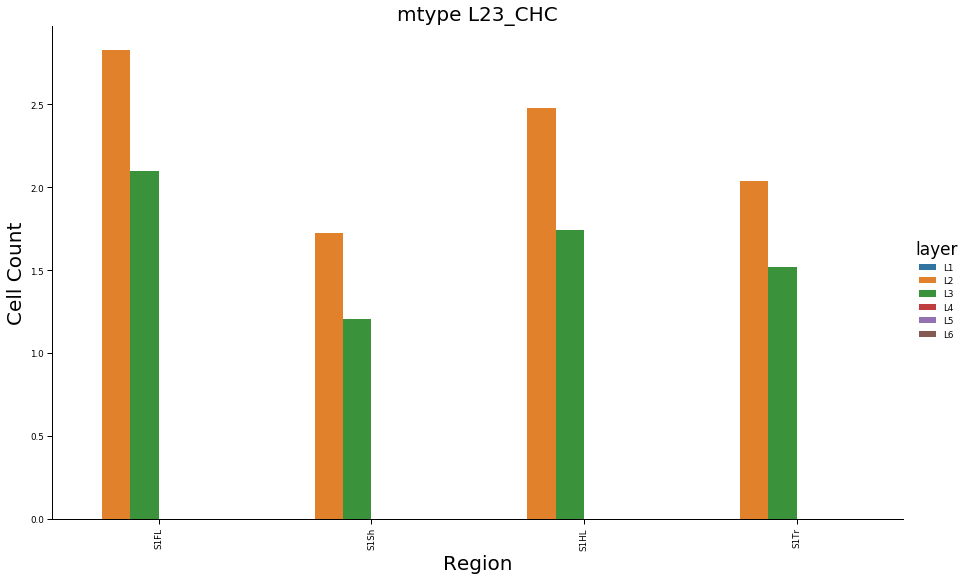

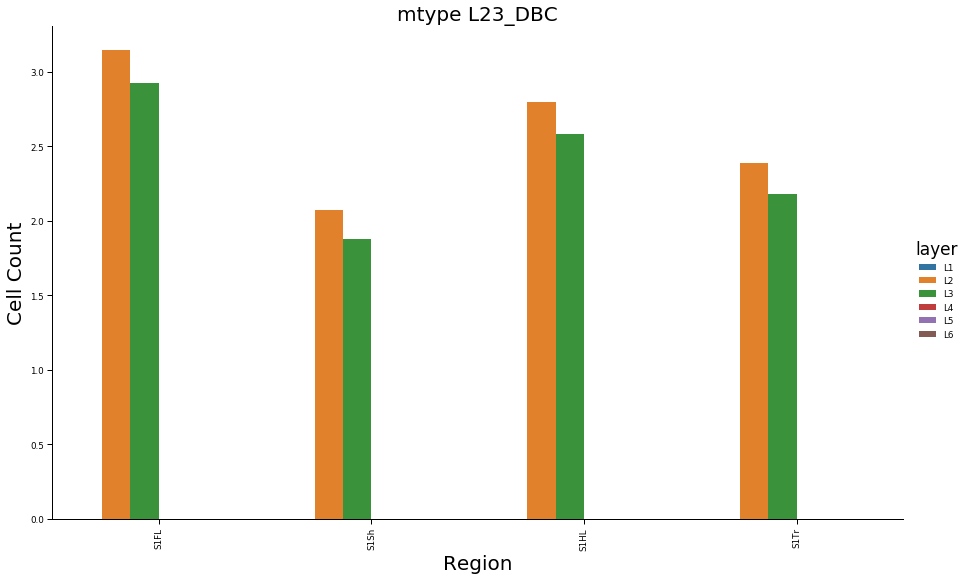

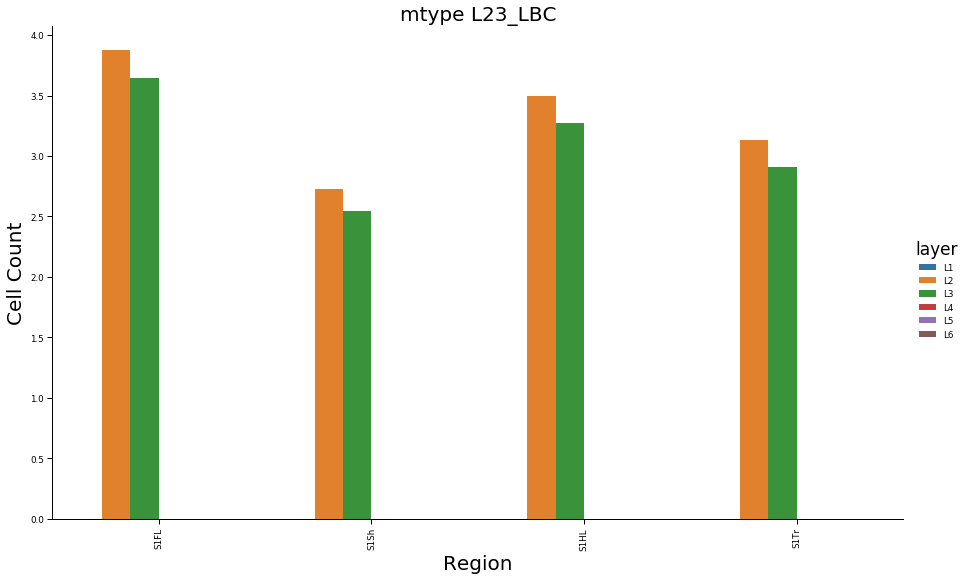

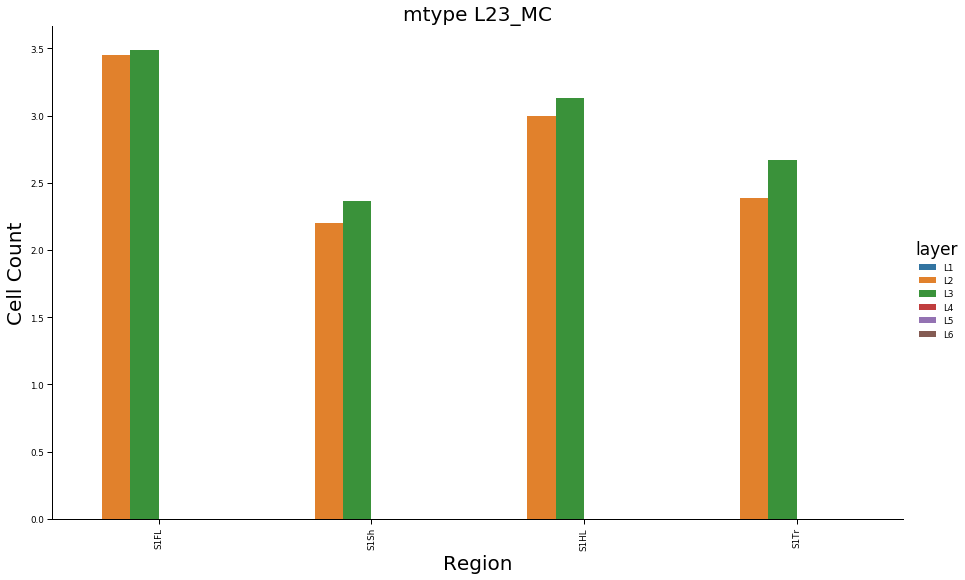

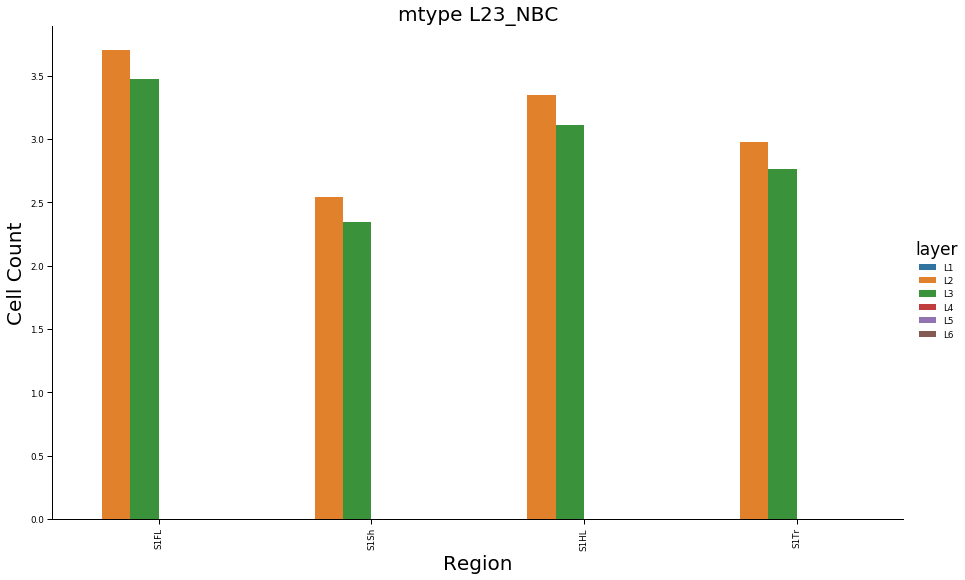

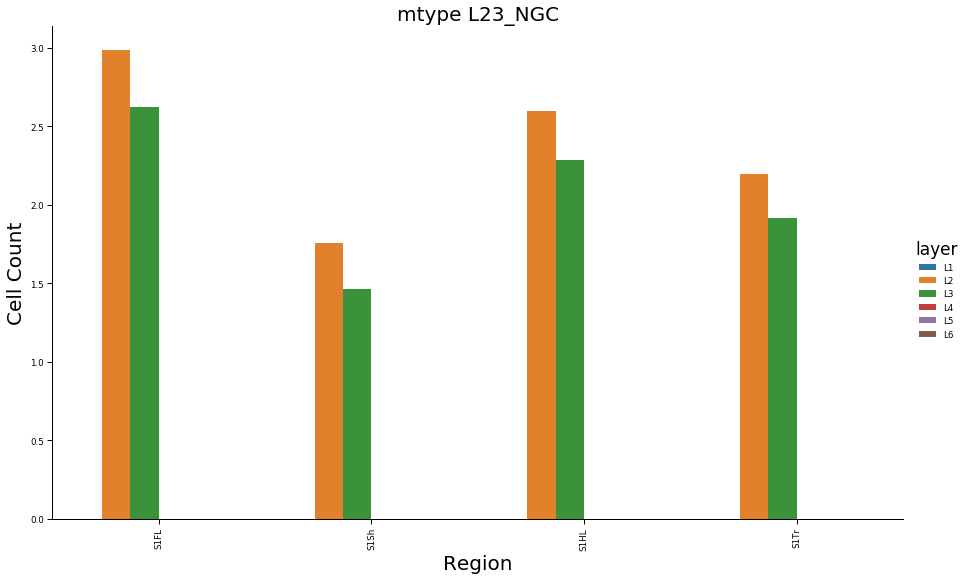

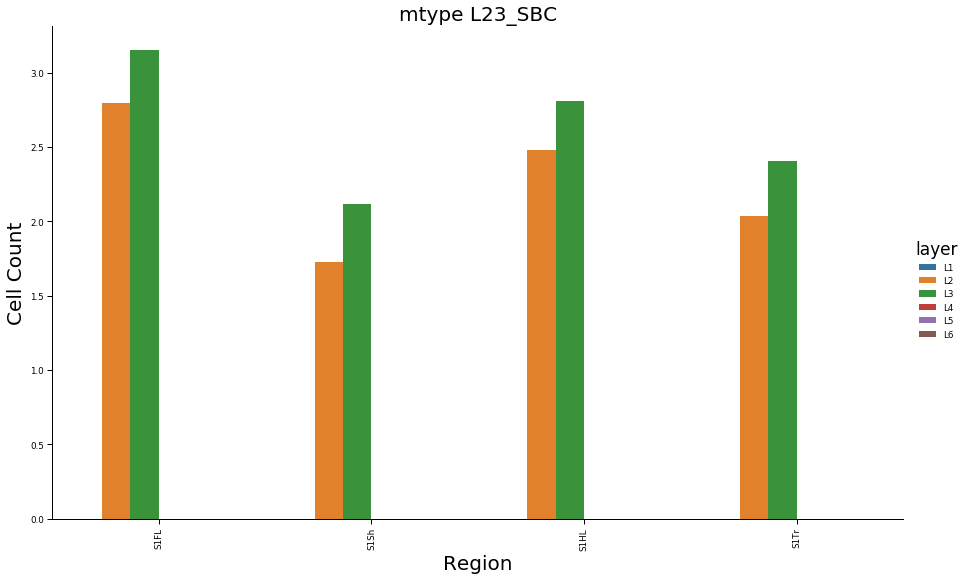

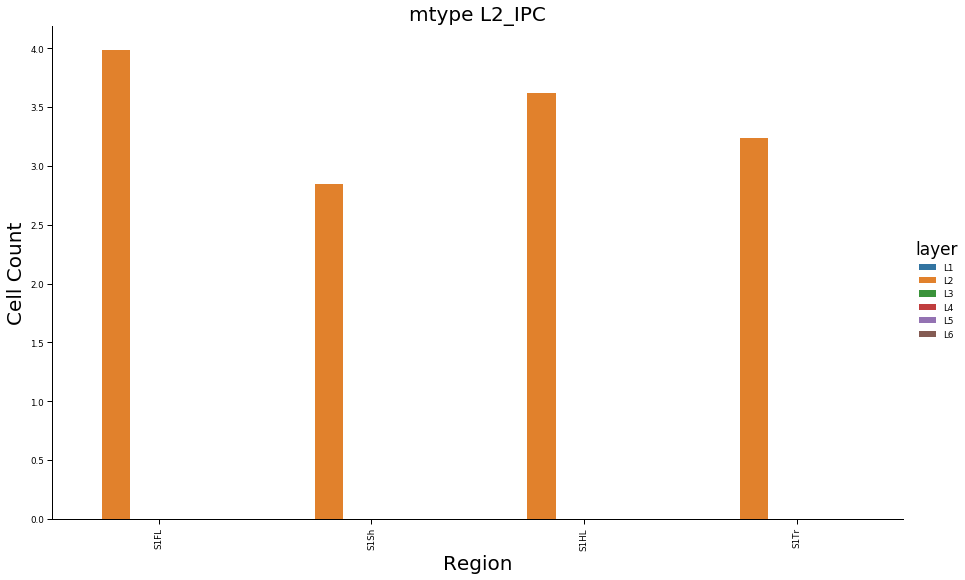

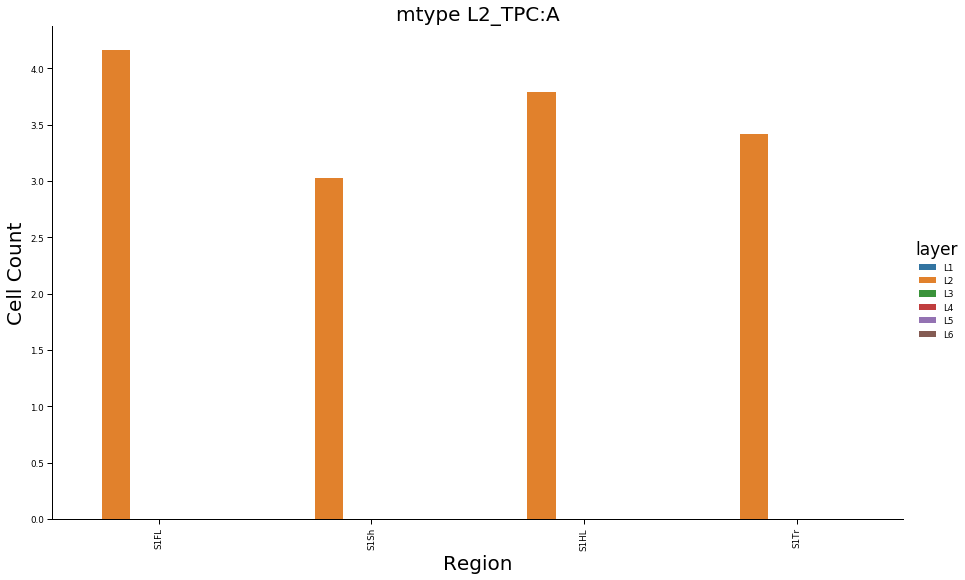

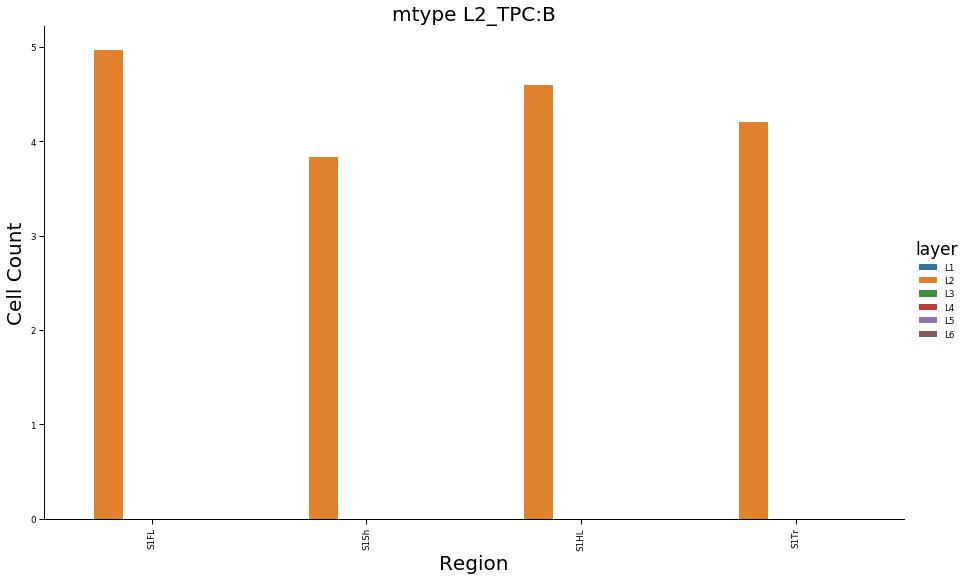

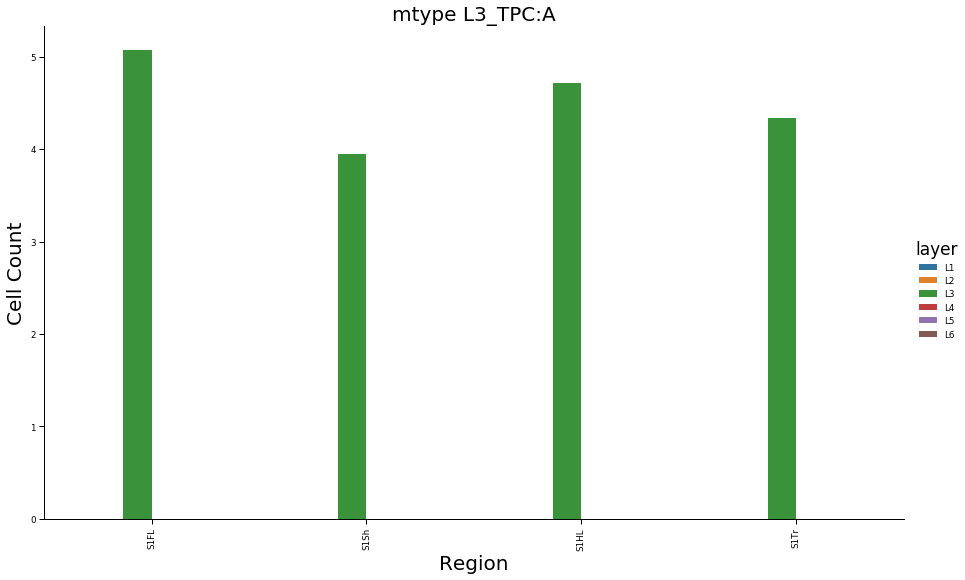

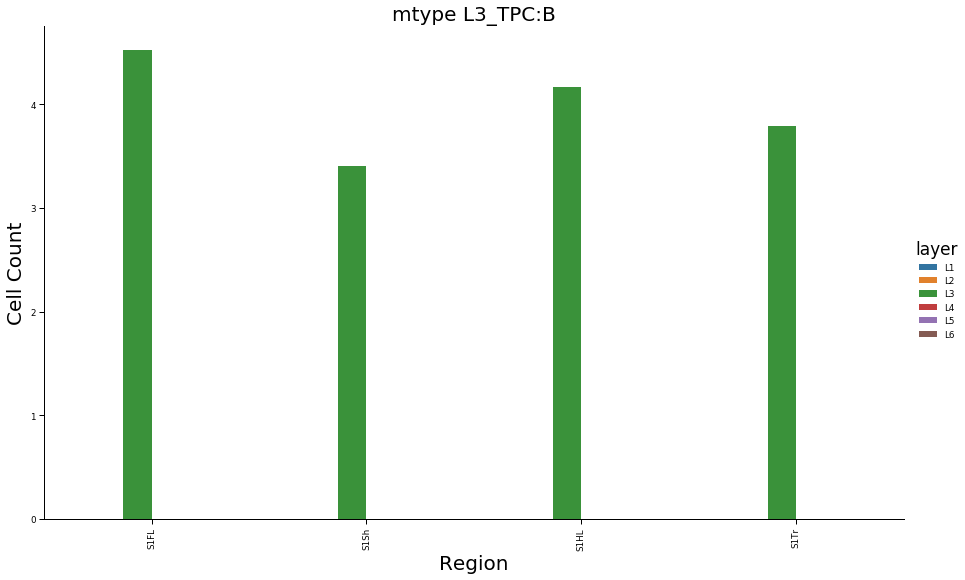

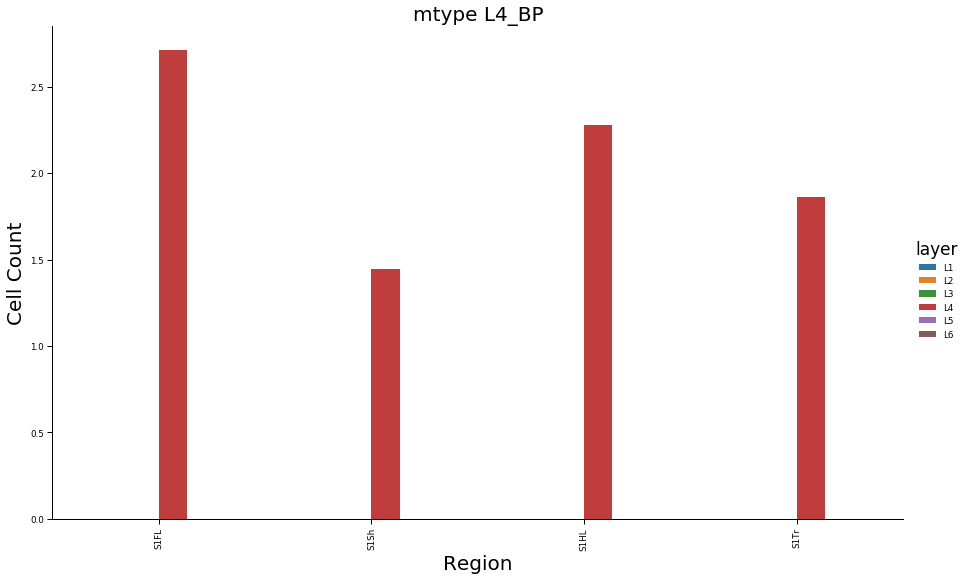

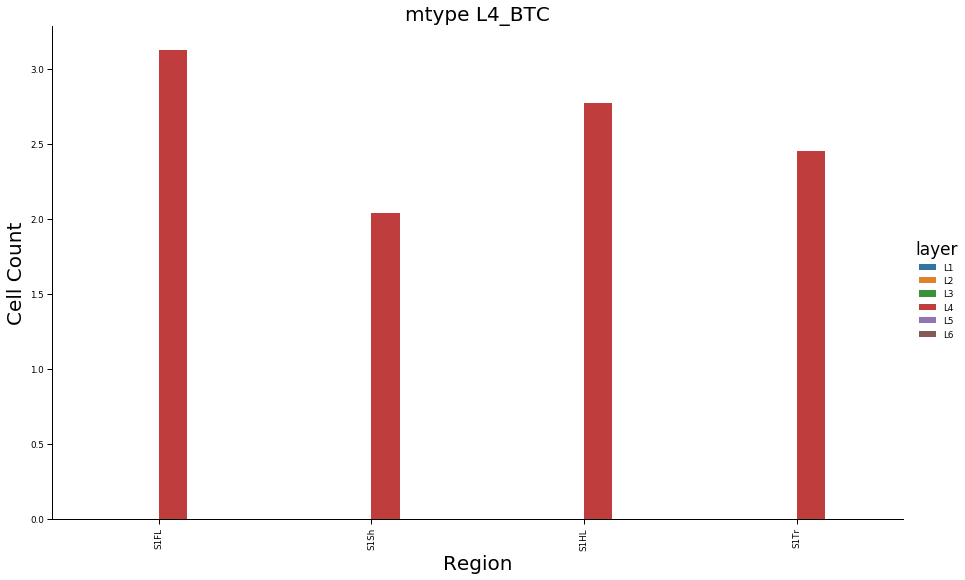

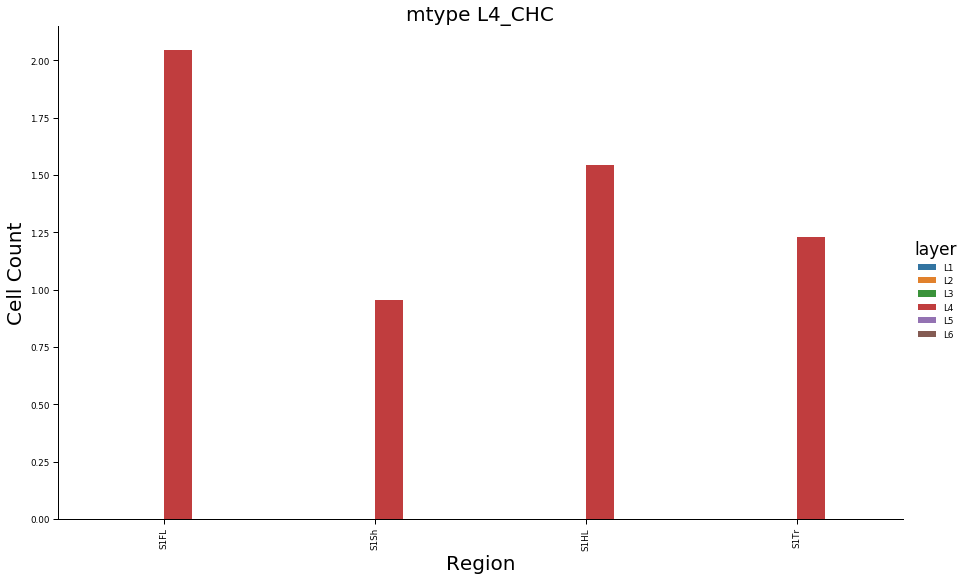

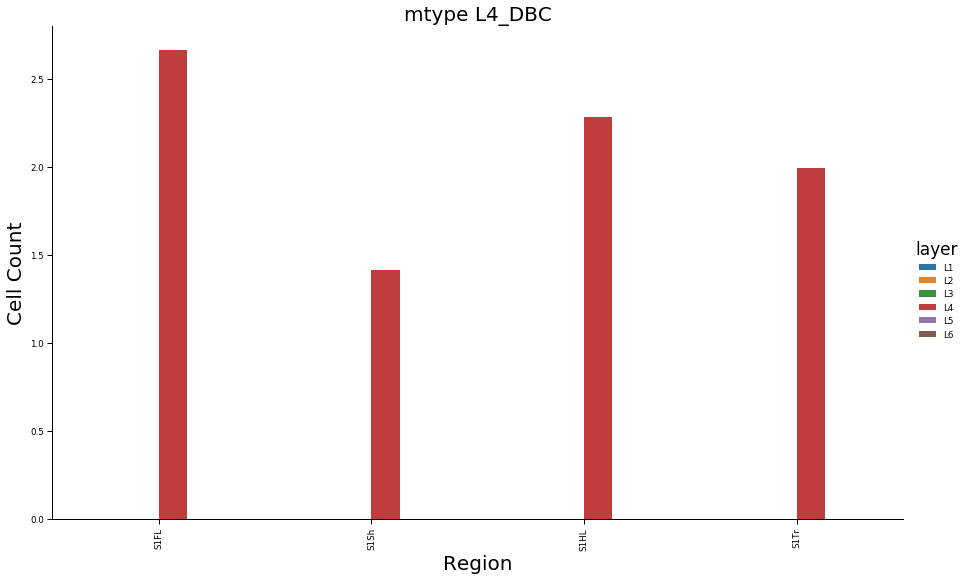

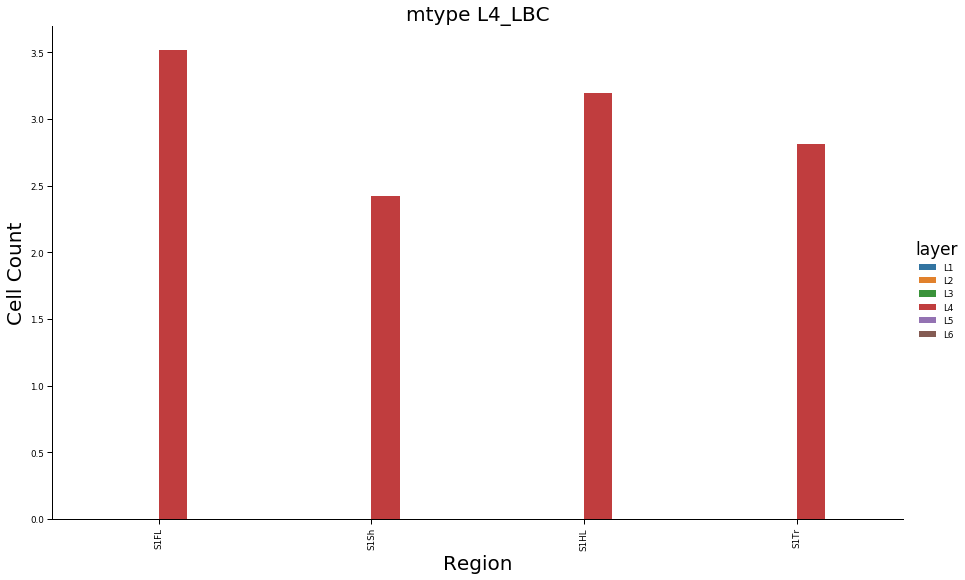

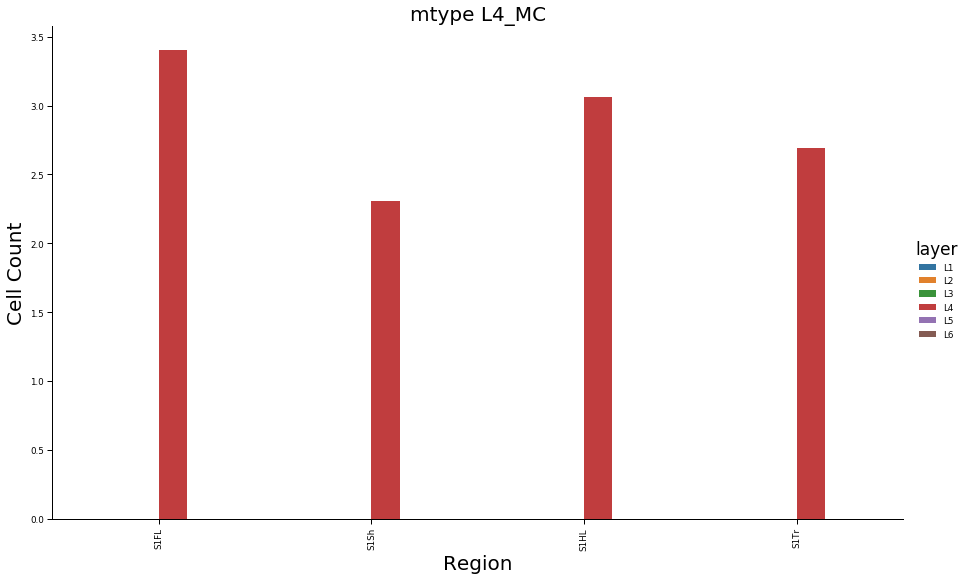

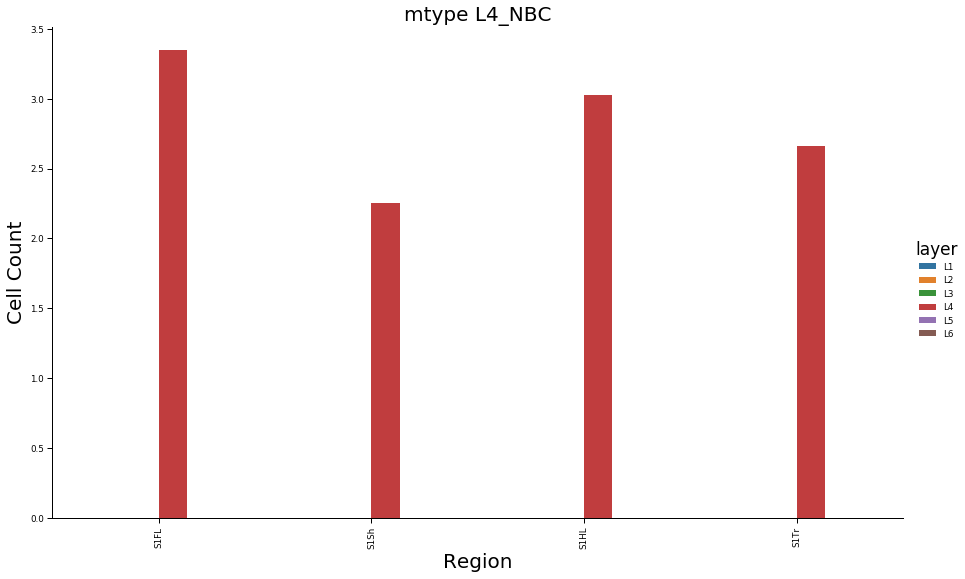

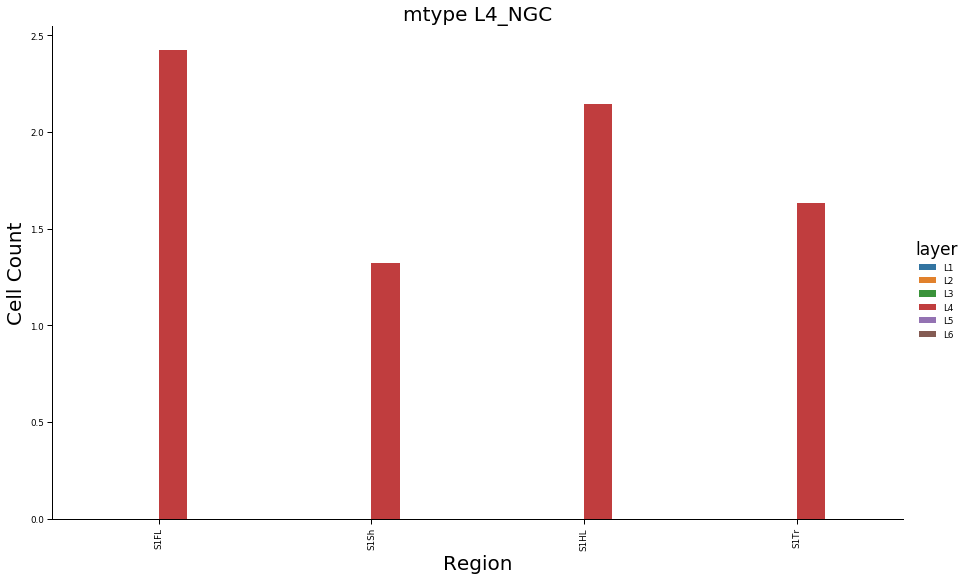

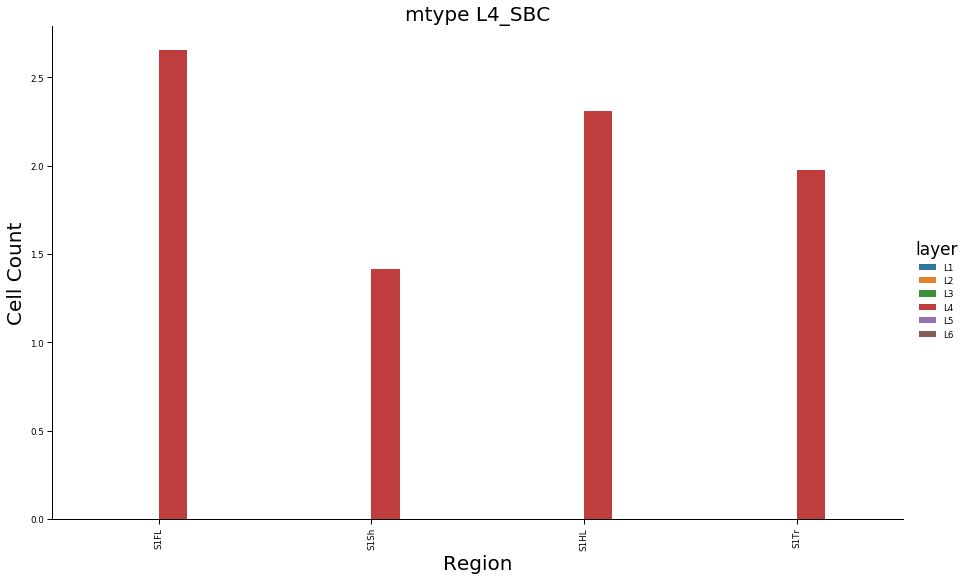

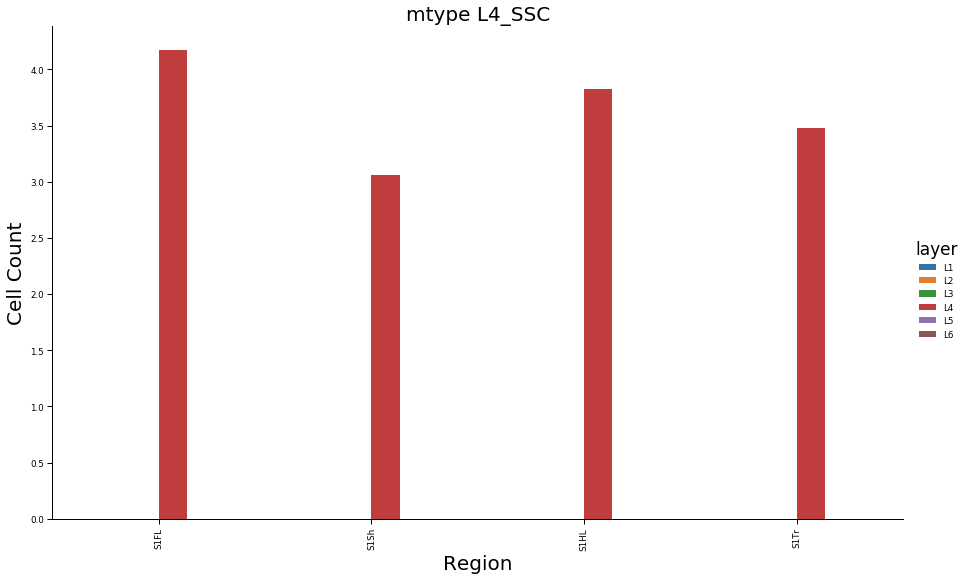

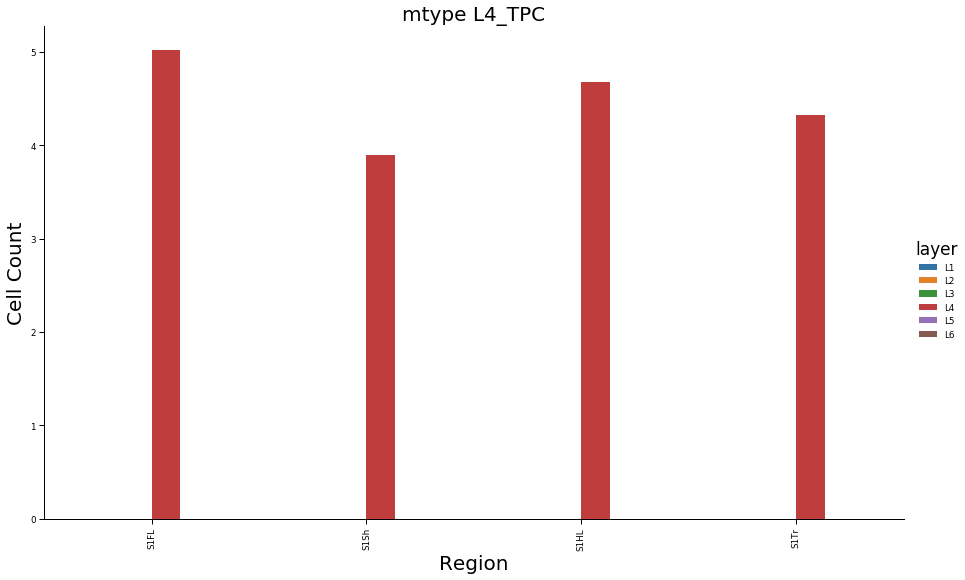

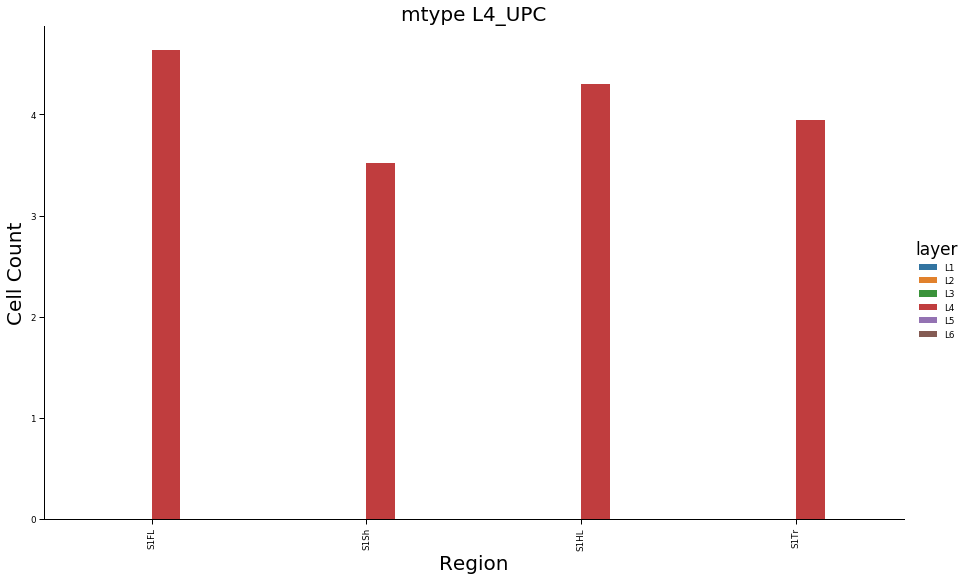

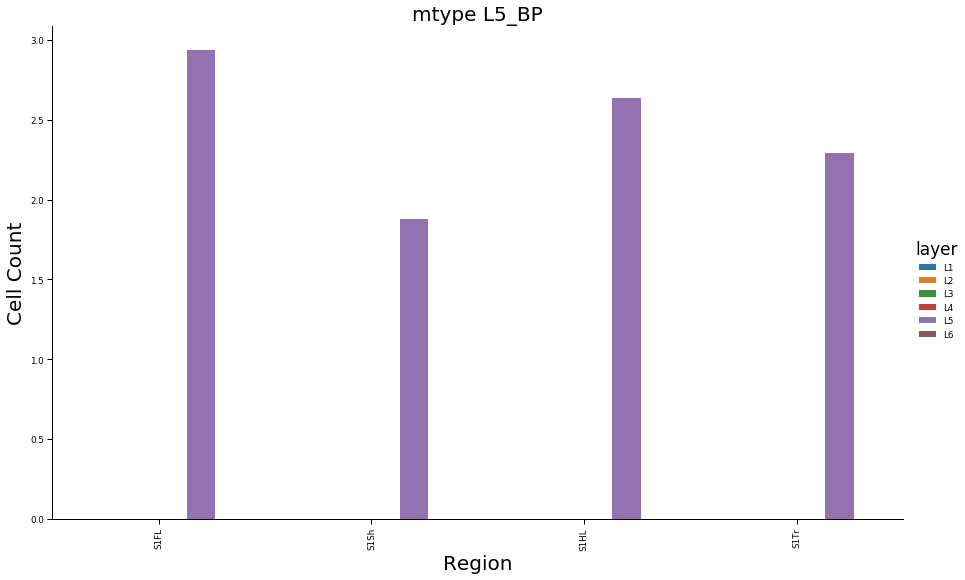

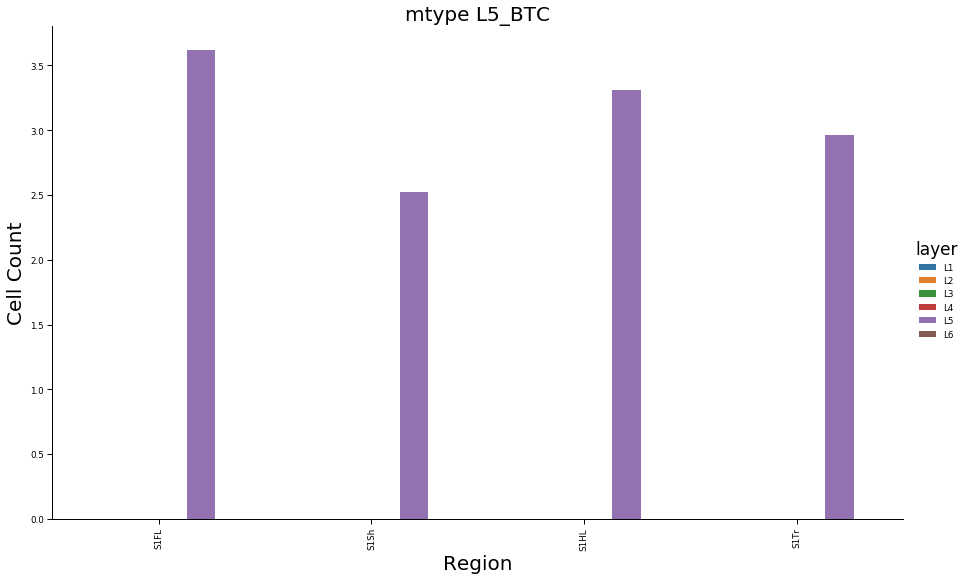

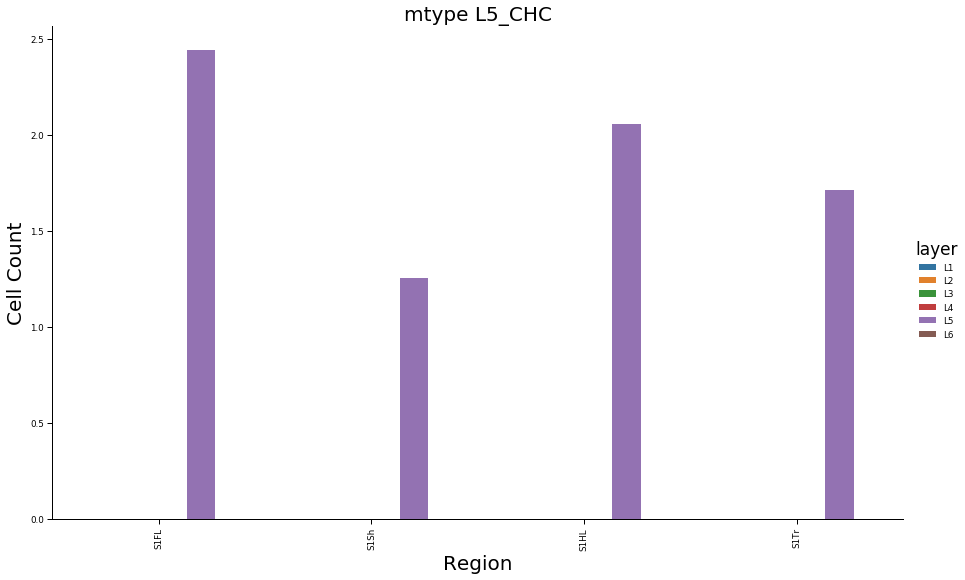

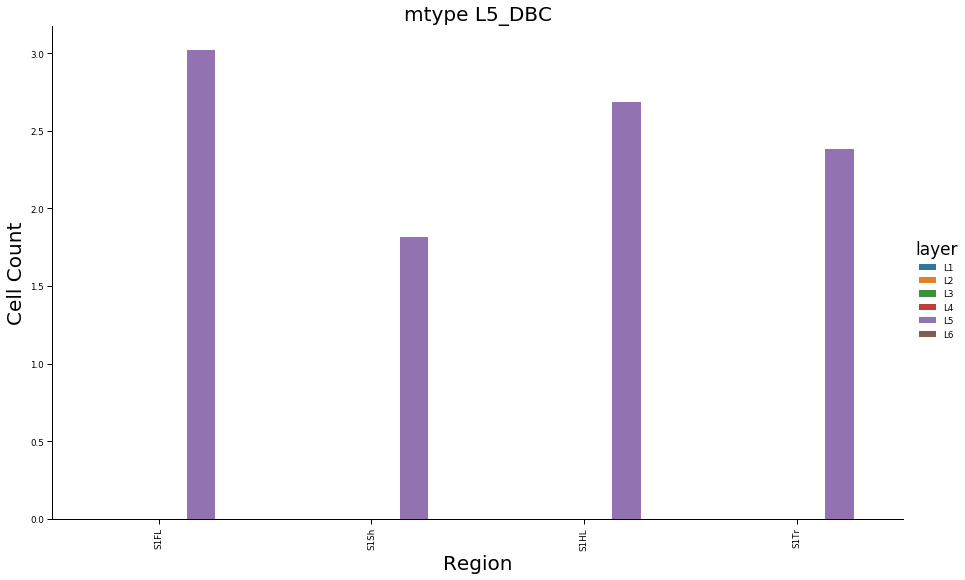

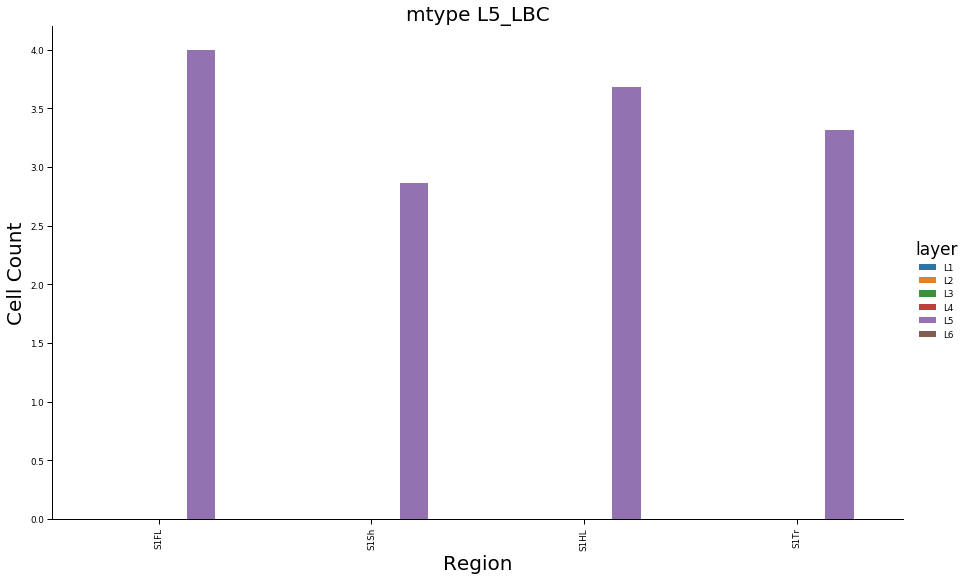

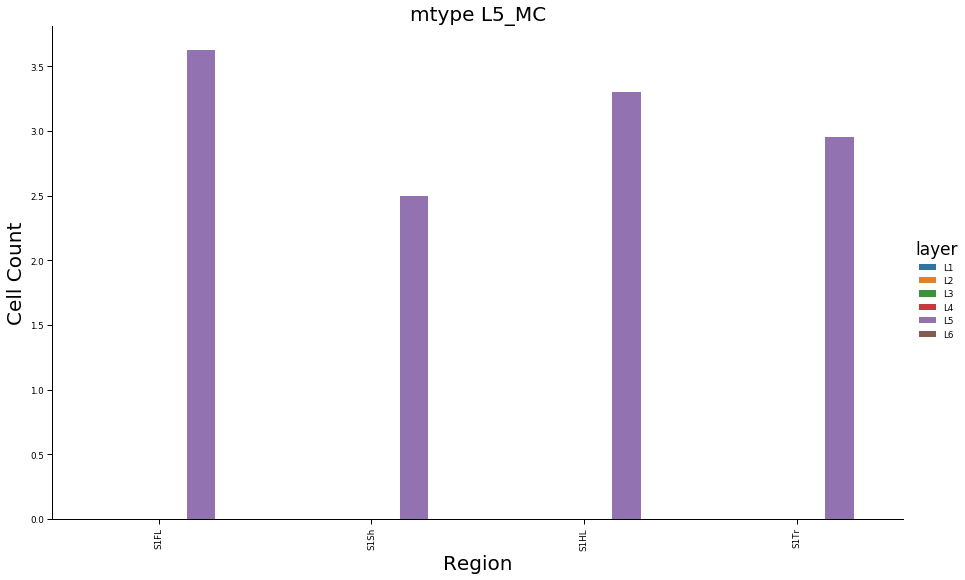

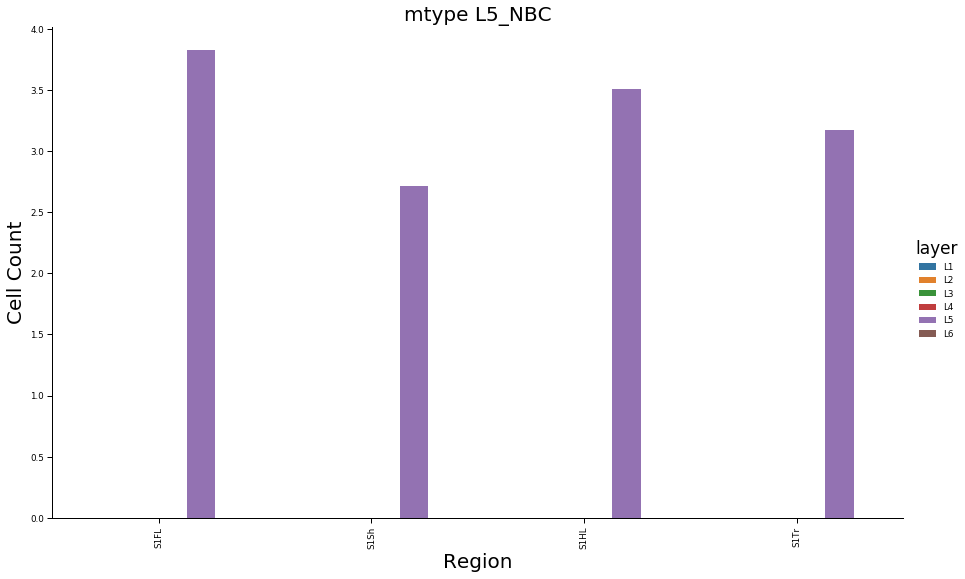

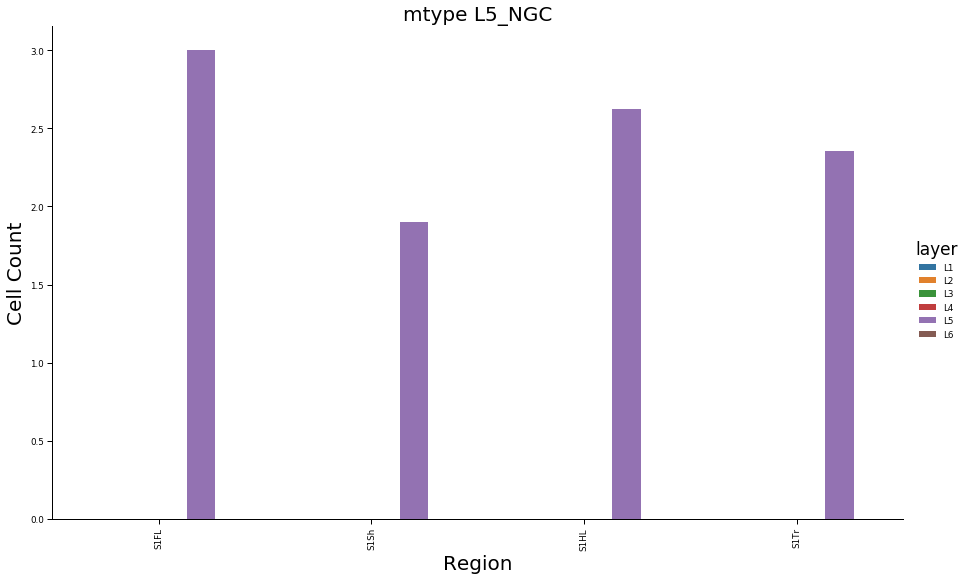

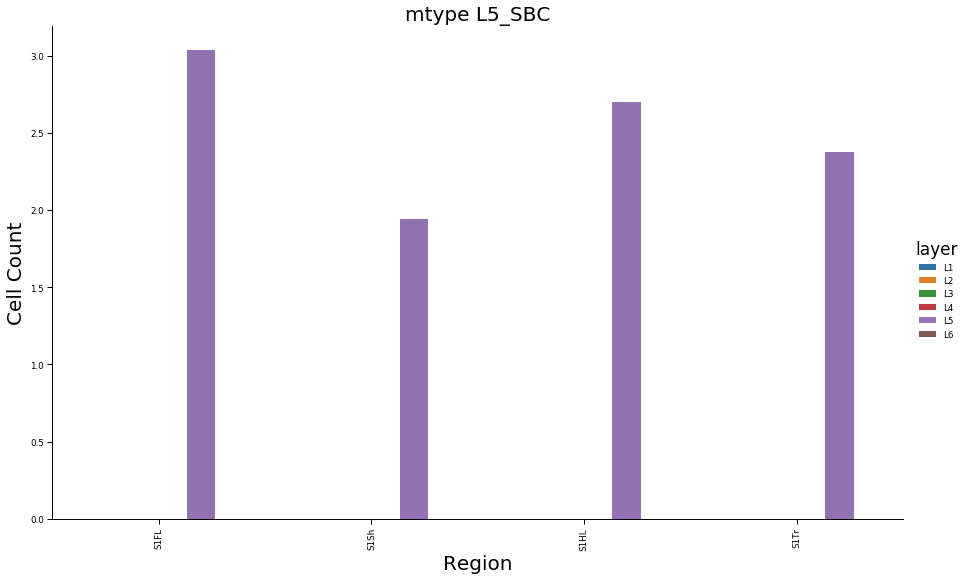

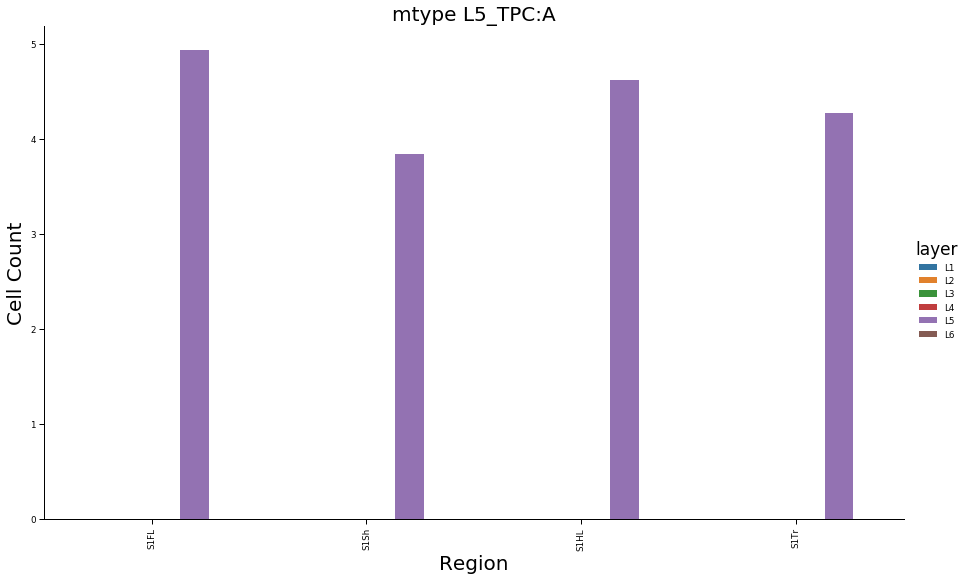

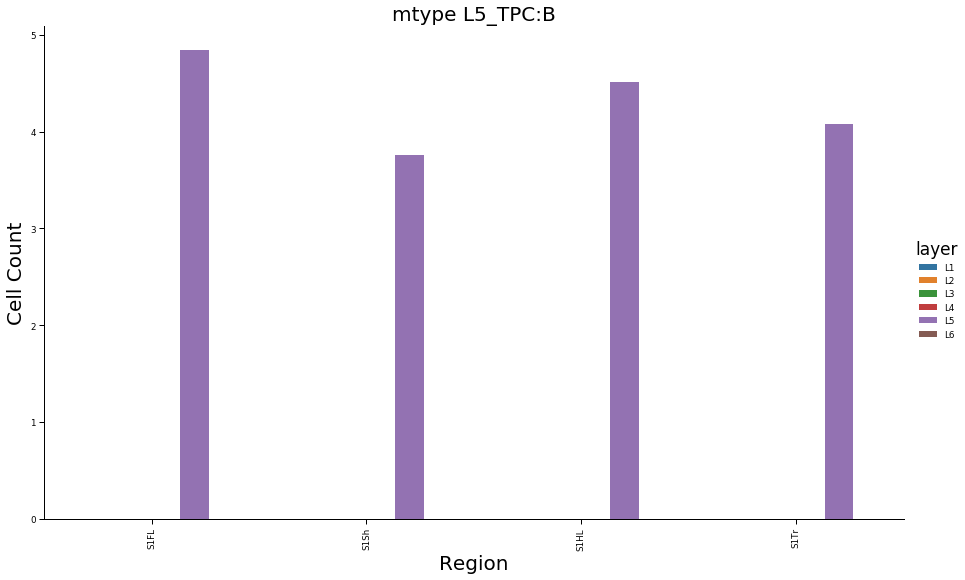

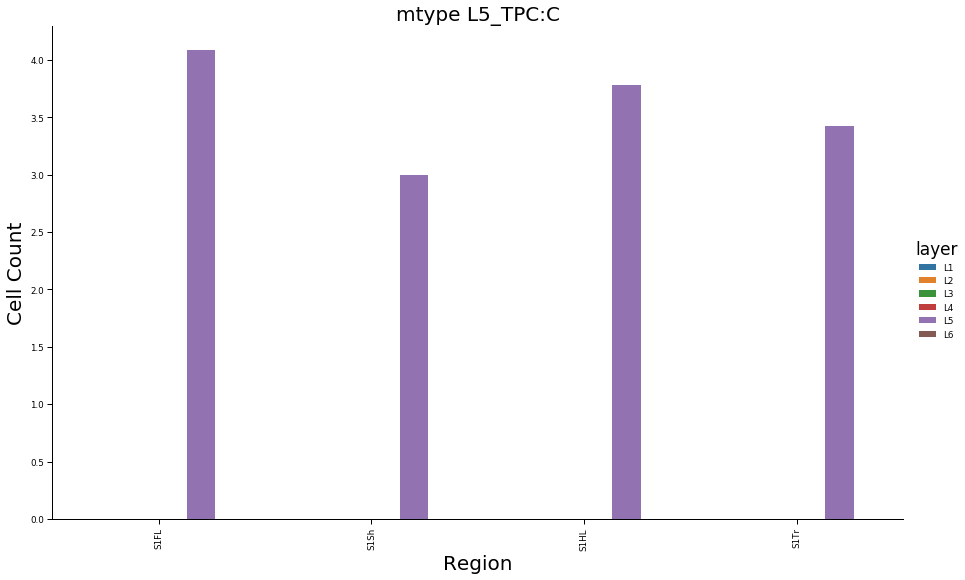

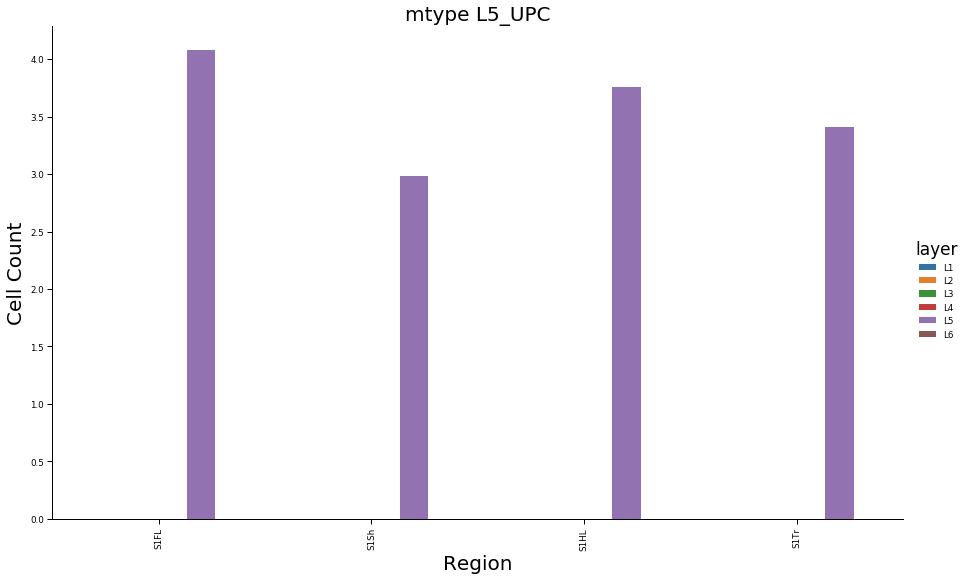

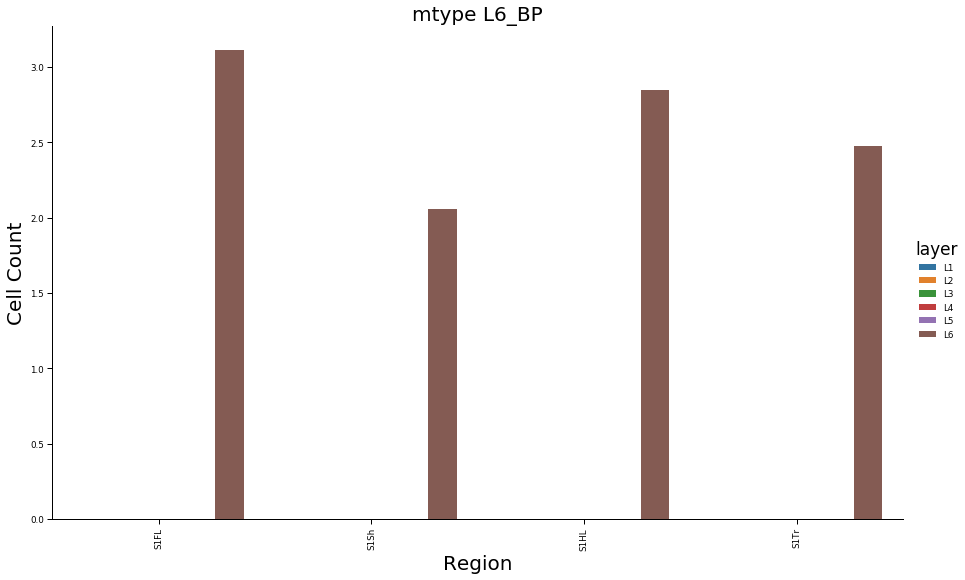

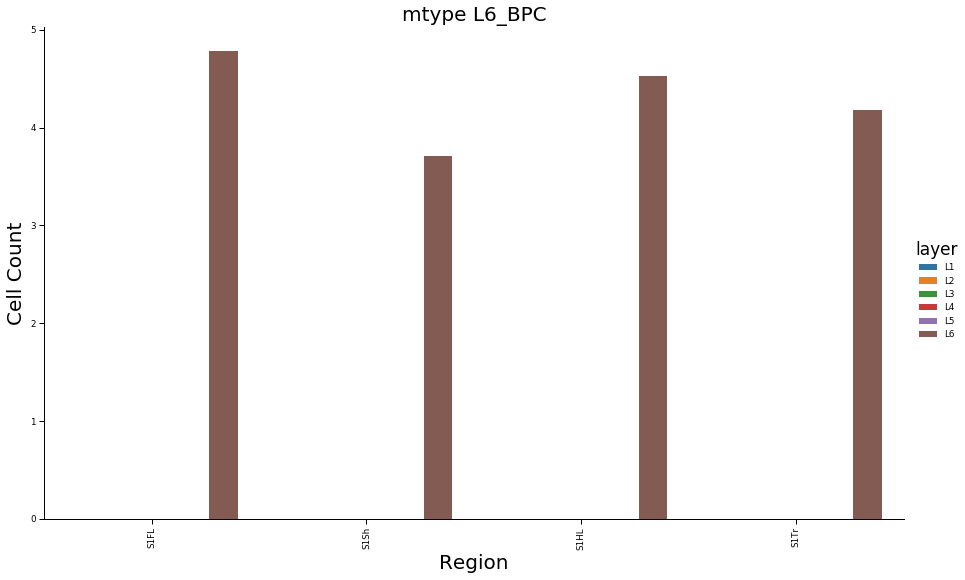

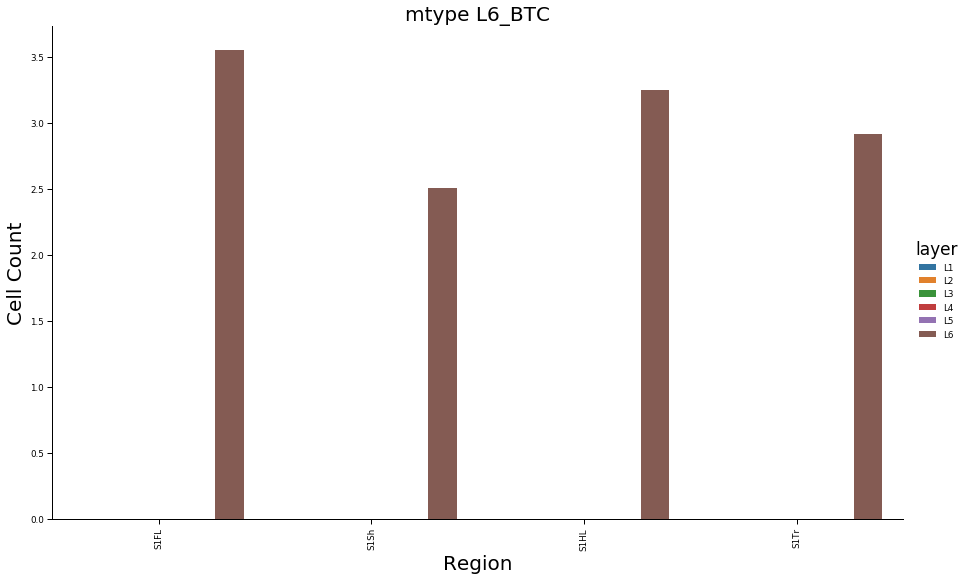

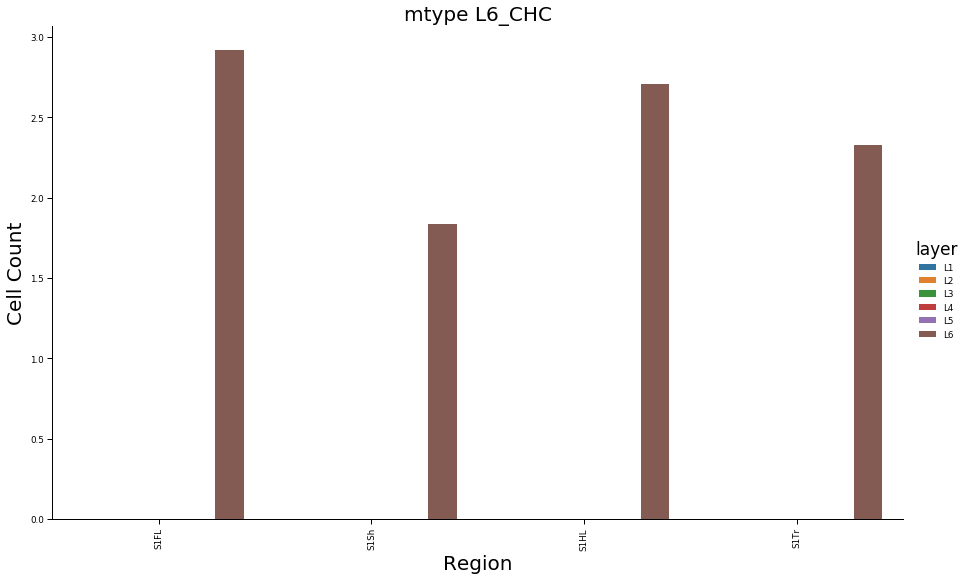

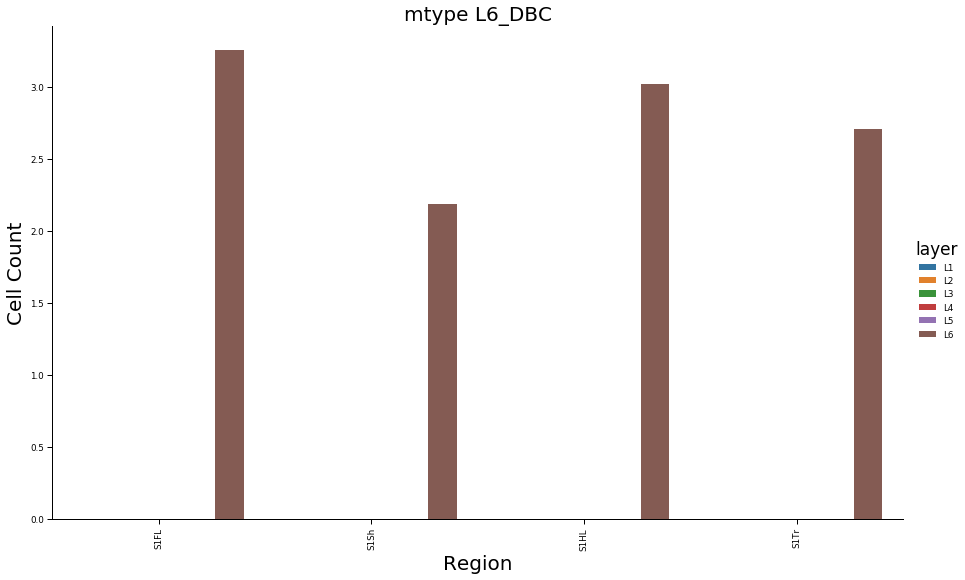

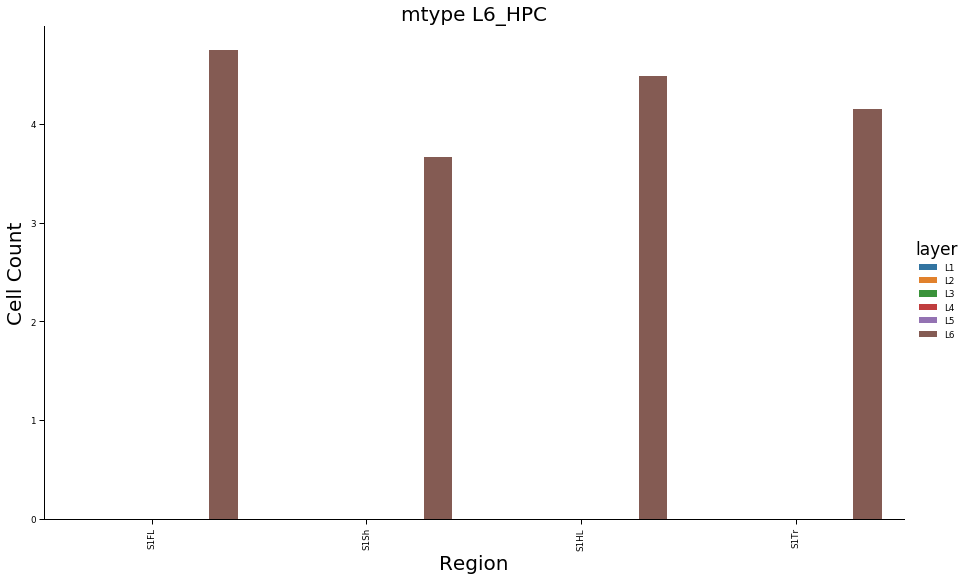

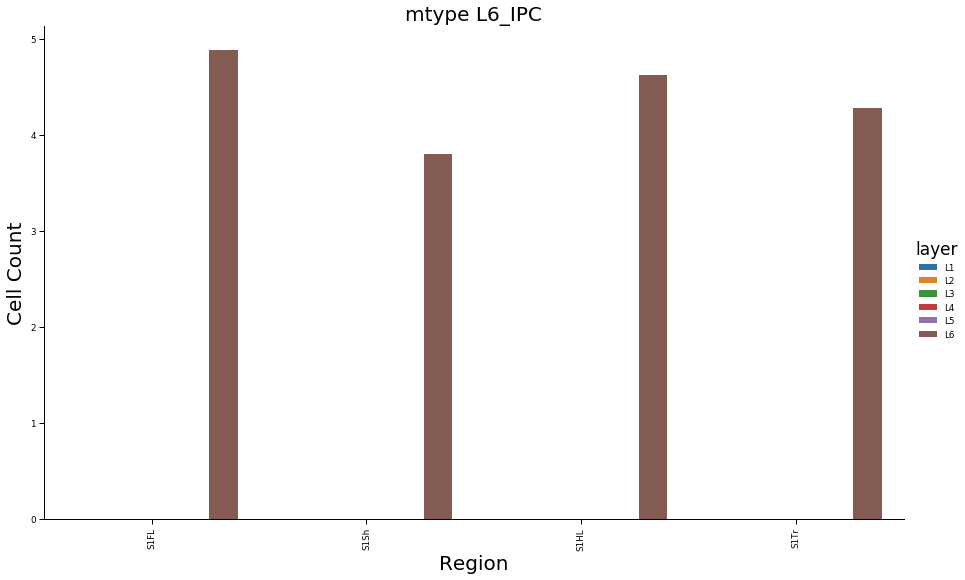

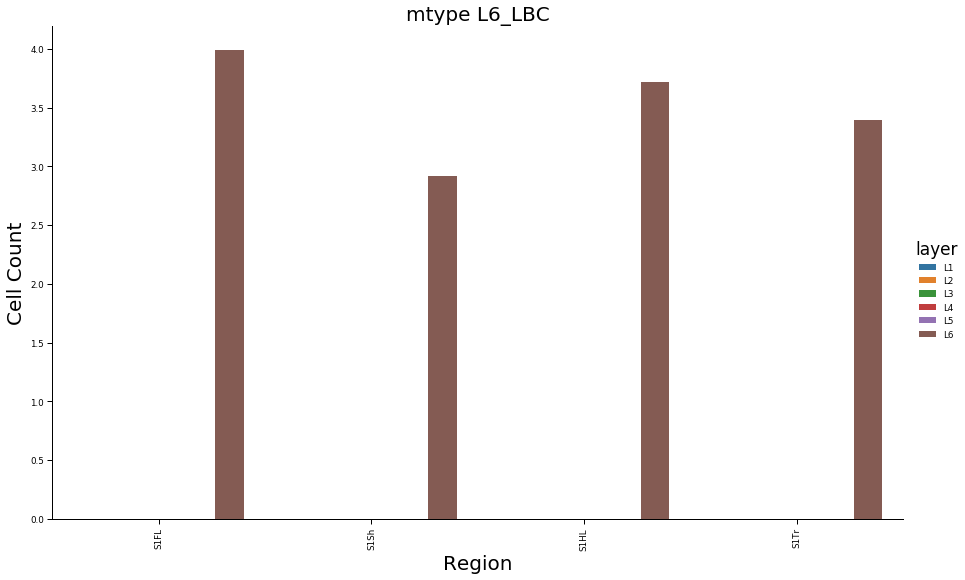

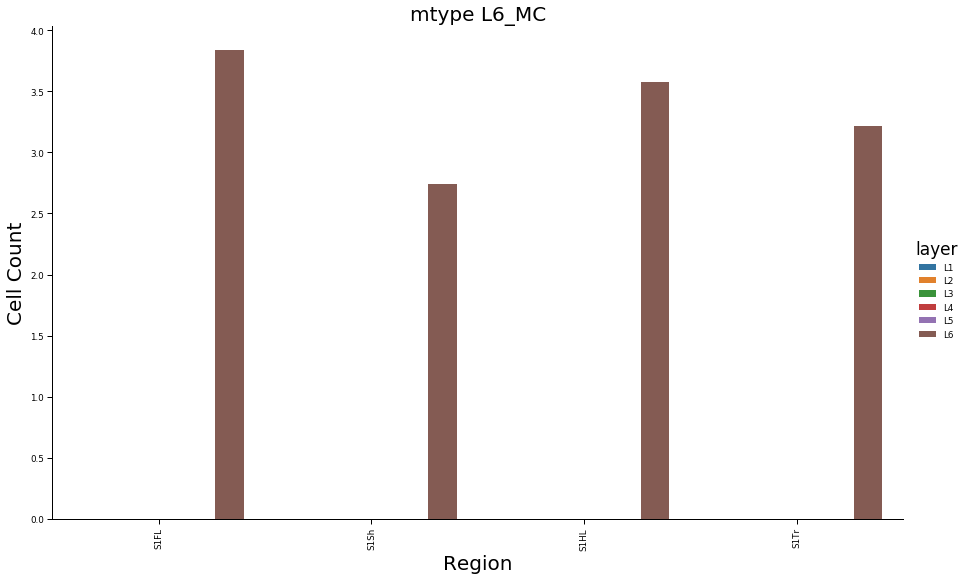

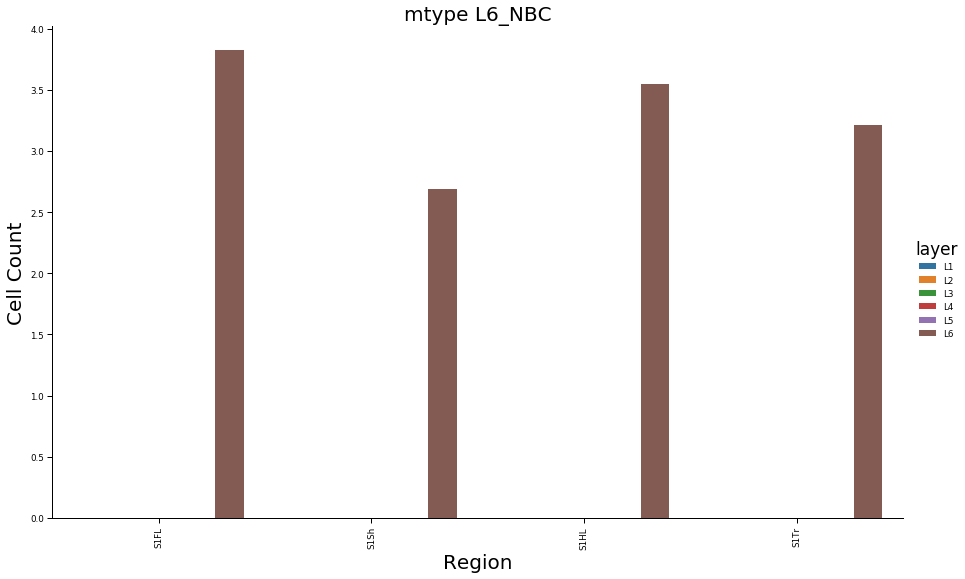

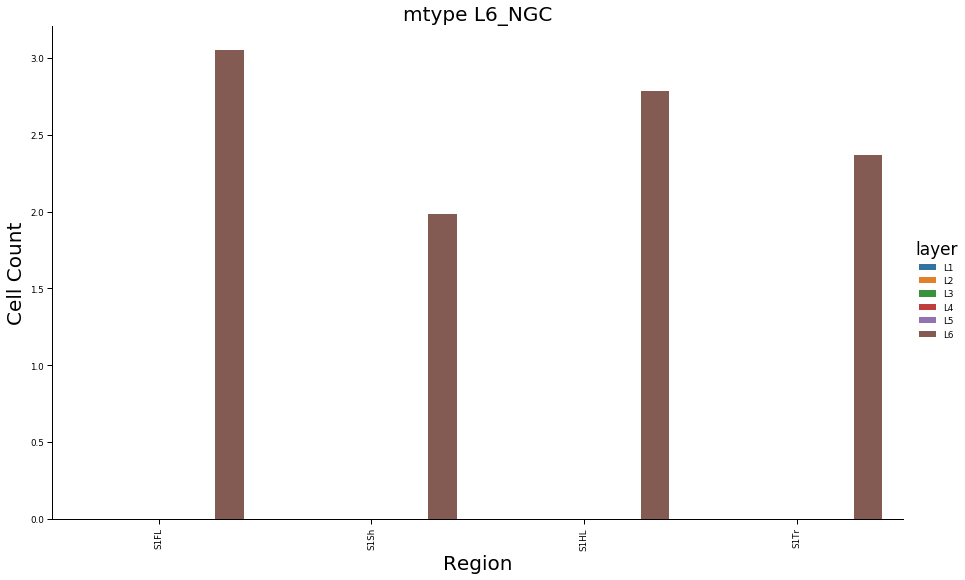

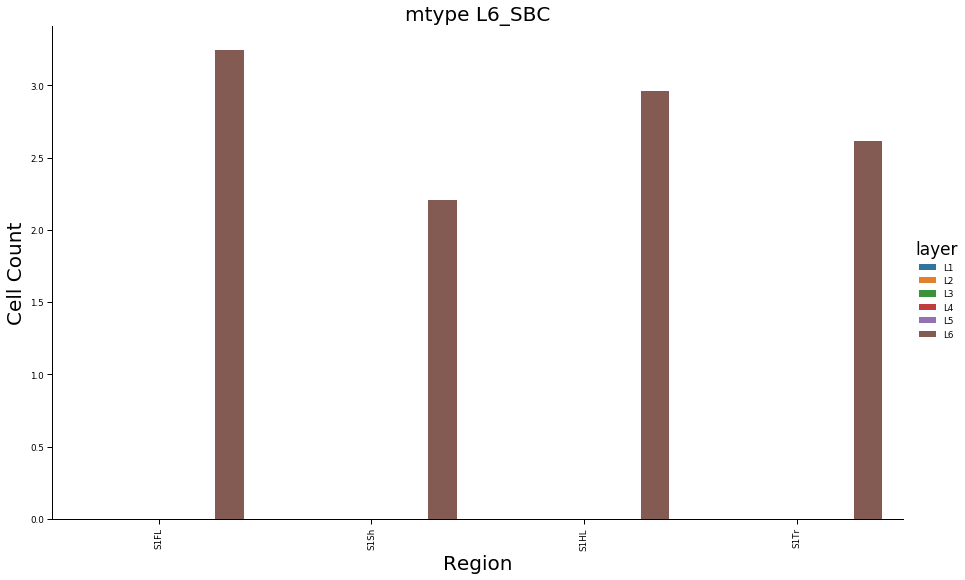

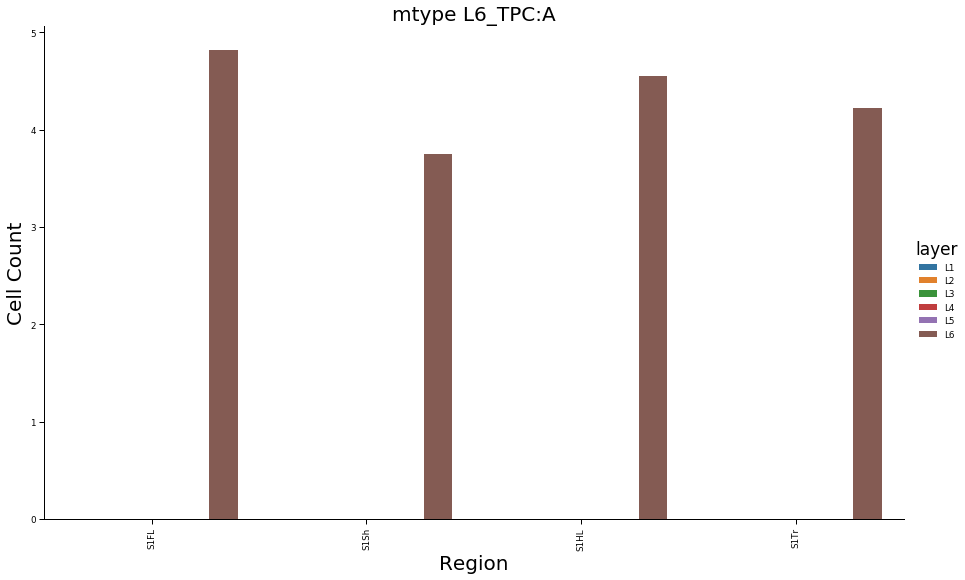

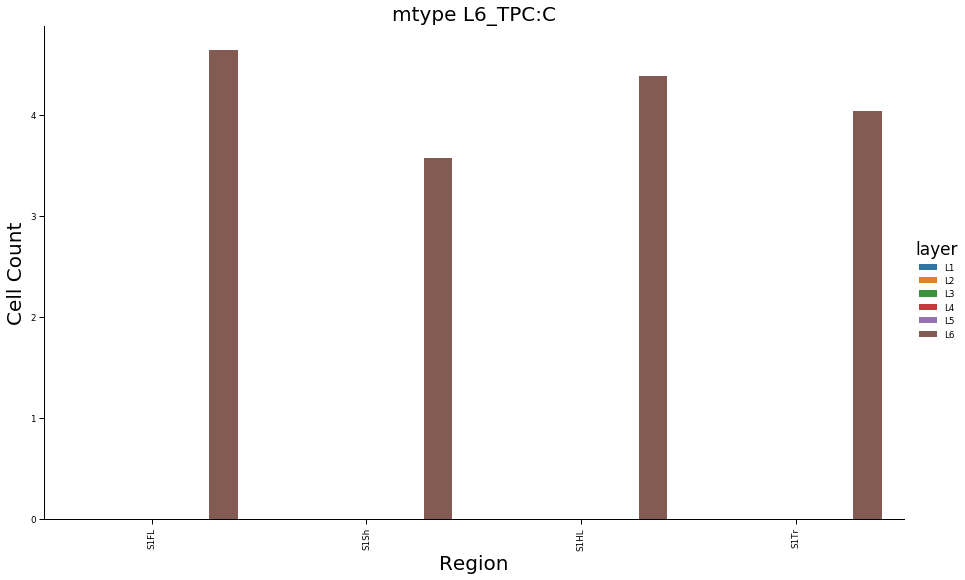

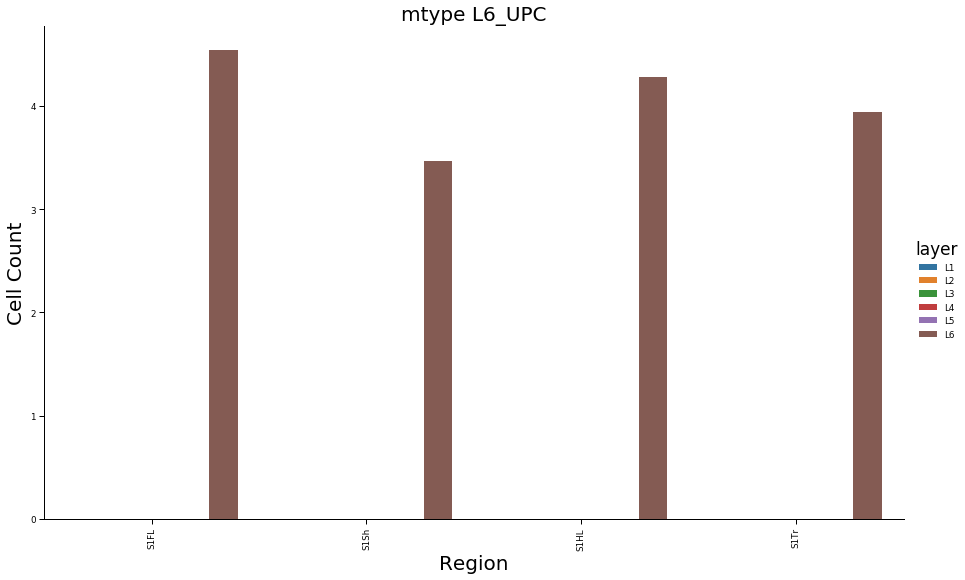

In [35]:
report_mtype_cell_counts =\
    analysis_mtype_cell_count(circuit_model, adapter)

In [24]:
reporter.post(report_mtype_cell_counts)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
.post(report=<neuro_dmt.analysis.reporting.CircuitAnalysisReport object at 0x7ffe791b7f98>,
                   template=None,
                   path_output_folder=None,
                   output_subfolder=None,
                   report_file_name=report.html,
                   strict=False,
                   with_time_stamp=True,
                   path_main_report=None,
                   title_main_report=None,
                   section_index=None,
                   chapter_index=None)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-09 13:00:50>                                                      
Post report mtype_cell_count_by_region_layer at
	 /gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/mtype_cell_count_

'/gpfs/bbp.cscs.ch/home/sood/work/validations/notebooks/reports/analyses/mtype_cell_count_by_region_layer/20200309/131845'

The analysis for mtype cell counts above counted cells by region, layer.
Count of mtypes by region will be more appropriate when we want to determine 
how to measure connectome properties.
We can define such an analysis:

In [36]:
analysis_regional_mtype_cell_count =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["mtype_cell_count"],
        introduction="""
        Number of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions, labels=["region"]),
        sample_measurement=measurement_mtype_cell_count_exhaustive,
        sample_size=1,
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        measurement_collection=measurement.collection.series_type,
        plotter=MultiPlot(
            mvar="region",
            plotter=Bars(xvar="mtype",
                     xlabel="mtype",
                     yvar="mtype_cell_count",
                     ylabel="Cell Count")),
        report=CircuitAnalysisReport)

  0%|          | 0/4 [00:00<?, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1FL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1FL'}



 25%|██▌       | 1/4 [00:03<00:11,  3.80s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Sh'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Sh'}



 50%|█████     | 2/4 [00:05<00:06,  3.19s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}



 75%|███████▌  | 3/4 [00:08<00:03,  3.12s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1Tr'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1Tr'}



100%|██████████| 4/4 [00:10<00:00,  2.83s/it]


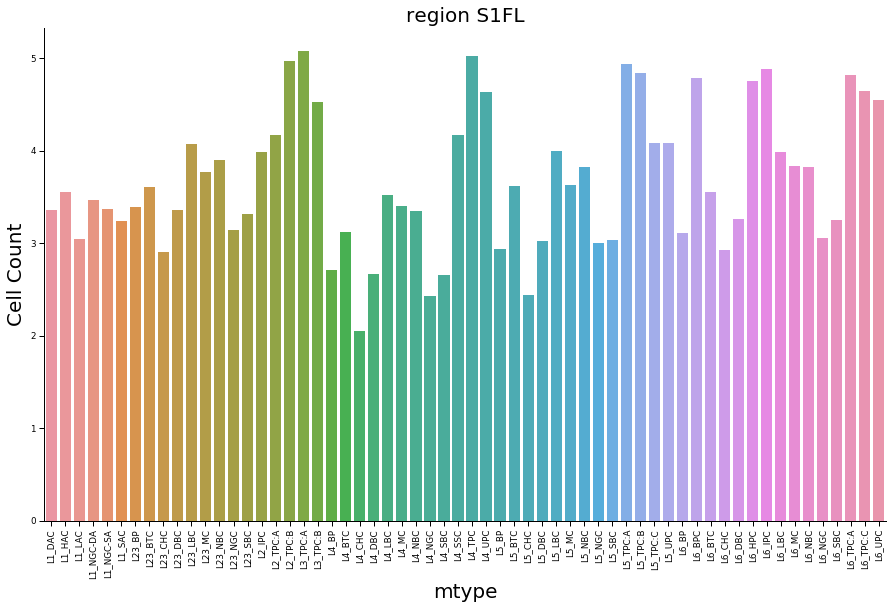

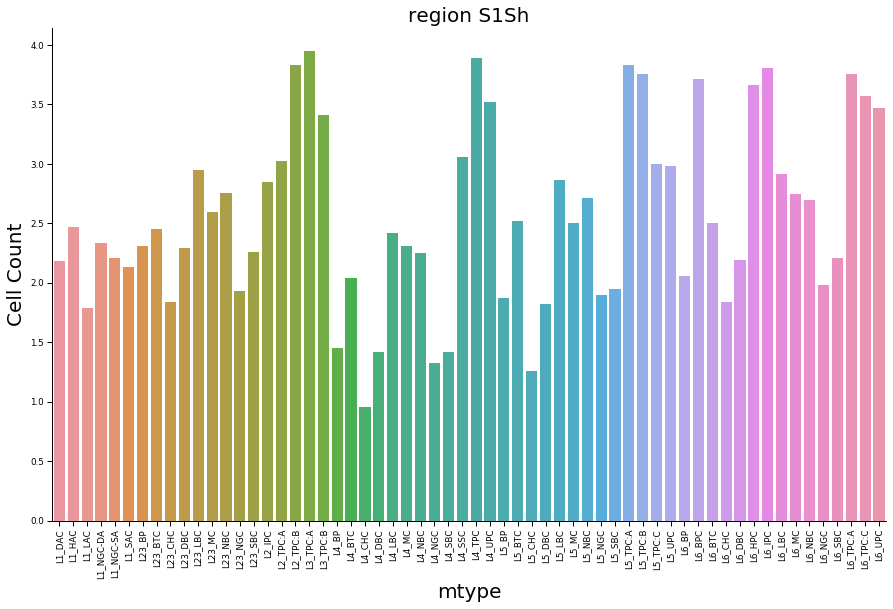

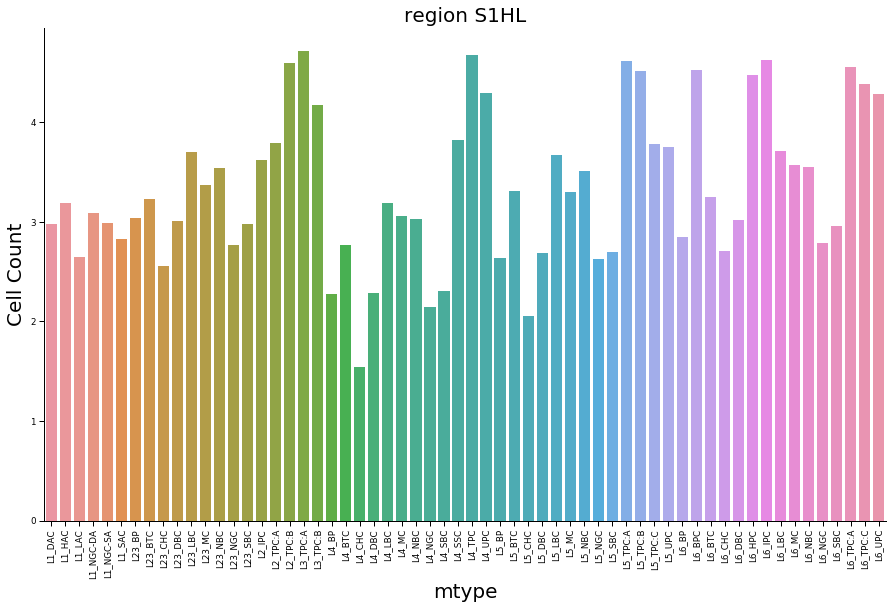

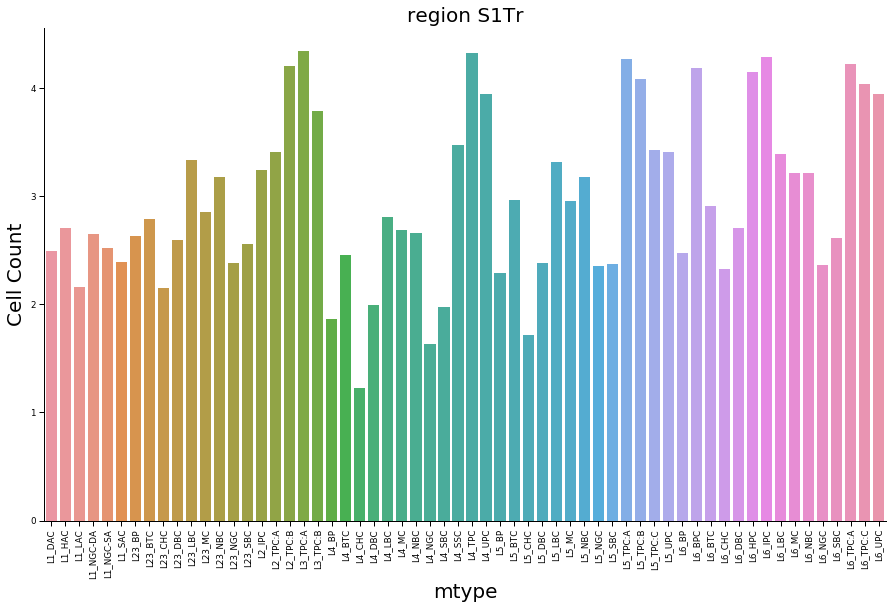

In [37]:
report_regional_mtype_cell_counts =\
    analysis_regional_mtype_cell_count(circuit_model, adapter)

In [39]:
mcc_s1hl =\
    report_regional_mtype_cell_counts.measurement.xs("S1HL", level="region")
mcc_s1hl.head()

mtype_cell_count
dataset               mtype                      
BlueBrainCircuitModel L1_DAC             2.983175
                      L1_HAC             3.190051
                      L1_LAC             2.642465
                      L1_NGC-DA          3.091315
                      L1_NGC-SA          2.988113

### Cell Density

The number of cells in an volume specified by a region and layer is determined 
by the size of volume.
We can take out the volume by analyzing cell densities.

In [102]:
def measurement_cell_density_using_sampling(
        adapter, circuit_model,
        size_roi=100., **query):
    """
    Measure the density of cells in a spatial location specified by the query.
    """
    box = random_box(adapter, circuit_model, size_roi=size_roi, **query)
    
    if box is None:
        return 0.
    count_cells = adapter.get_cells(circuit_model, roi=box).shape[0]
    volume_spatial = box.volume
    return count_cells / volume_spatial

In [103]:
phenomenon["cell_density"] =\
    Phenomenon("Cell Density", 
               description="Number of cells in a unit volume.",
               group="Composition")
    
analysis_cell_density =\
    BrainCircuitAnalysis(
        phenomenon=phenomenon["cell_density"],
        introduction="""
        Density of cells in each of the populated sub-regions are analyzed.
        """,
        methods="""
        Cells were counted in randomly sampled cubic boxes of side $size_roi.
        Each sampled box was conditioned to lie in the spatial location 
        specified by brain-region and layer queried. For each spatial query,
        the measured sample contained $sample_size boxes.
        """,
        AdapterInterface=CompositionAdapterInterface,
        measurement_parameters=Parameters(get_regions_and_layers),
        sample_measurement=measurement_cell_density_using_sampling,
        sample_size=20,
        plotter=Bars(xvar="region",
                     xlabel="Region",
                     yvar="cell_density",
                     ylabel="Cell Density",
                     gvar="region"),
        report=CircuitAnalysisReport)

In [104]:
report_cell_density = analysis_cell_density(circuit_model, adapter)





  0%|          | 0/480 [00:00<?, ?it/s]

NameError: name 'random_box' is not defined

In [59]:
reporter.post(report_cell_density)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/analysis/reporting/__init__.py Logger
INFO@<2020-03-05 12:29:15>                                                      
Post report cell_density at
	 /Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025



'/Users/vishalsoodmuchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/notebooks/reports/analyses/cell_density/20200305/144025'

# Connectome

The connectome of a circuit consists of synapses between the cells.

## Efferent connections of cells 

An efferent connection is an outgoing connection,
and the cell in question the pre-synaptic cell.
We have developed to make connectome measurements on the circuit.
We use this tool to define a measurement of efferent degree.

In [11]:
reload(pm)
efferent_degree =\
    pm.PathwayMeasurement(
        direction="EFF",
        value=lambda connections: 1.,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_size=100,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000)

In [203]:
effdeg_serial =\
    pm.PathwayMeasurement(
        direction="EFF",
        value = lambda connections: 1,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.random,
        sample_size=10,
        processing_methodology=terminology.processing_methodology.serial,
        return_primary_info=True)

In [204]:
sample_effdeg =\
    effdeg_serial.sample(
        circuit_model, adapter)

In [207]:
se1 = next(sample_effdeg)

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
Traceback:
	filename: 	/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	630
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 16
number secondary.target 1913723

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-08 11:57:33>                                                 
PathwayMeasurement.get_connections(...)
queried primary gids 1
queried secondary gids 1913723

/home/muchu/work/bbp/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py

In [219]:
se1[np.logical_not(pd.isna(se1).values)].sum()

number_connections_efferent    275.0
dtype: float64

In [40]:
reload(pm)
affdeg_serial =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        sample_size=10,
        processing_methodology=terminology.processing_methodology.serial,
        return_primary_info=True,
        target={circuit_model: adapter.get_cells(circuit_model, region="S1HL")})
sample_affdeg_serial =\
    affdeg_serial.sample(
        circuit_model, adapter)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}



In [88]:
reload(pm)
affdeg_batch =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=1000,
        return_primary_info=True,
        target=lambda cm, 
        #target={circuit_model: adapter.get_cells(circuit_model, region="S1HL")})
sample_affdeg_batch =\
    affdeg_batch.sample(
        circuit_model, adapter)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}



In [92]:
affdeg_l6tpca =\
    affdeg_batch.collect(
        circuit_model, adapter,
        post_synaptic_cell_group={"mtype": "L6_TPC:A"})

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'AFF', 'post_synaptic_cell_group': {'mtype': 'L6_TPC:A'}, 'pre_synaptic_cell_group': {}}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visoo


0it [00:00, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	498
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._batches(...)
cell mtypes [L6_TPC:A]
Categories (1, object): [L6_TPC:A]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	676
	code_context: 	['     


1it [00:33, 33.42s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  785473  L6_TPC:A
1  785475  L6_TPC:A
2  785482  L6_TPC:A
3  785485  L6_TPC:A
4  785489  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


2it [01:06, 33.20s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  788865  L6_TPC:A
1  788866  L6_TPC:A
2  788867  L6_TPC:A
3  788868  L6_TPC:A
4  788871  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


3it [01:40, 33.46s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  792401  L6_TPC:A
1  792410  L6_TPC:A
2  792411  L6_TPC:A
3  792413  L6_TPC:A
4  792415  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


4it [02:13, 33.30s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  795853  L6_TPC:A
1  795859  L6_TPC:A
2  795860  L6_TPC:A
3  795868  L6_TPC:A
4  795870  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


5it [02:47, 33.49s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  799362  L6_TPC:A
1  799366  L6_TPC:A
2  799370  L6_TPC:A
3  799374  L6_TPC:A
4  799376  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


6it [03:21, 33.77s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  802644  L6_TPC:A
1  802650  L6_TPC:A
2  802653  L6_TPC:A
3  802655  L6_TPC:A
4  802658  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


7it [03:53, 33.39s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  806148  L6_TPC:A
1  806152  L6_TPC:A
2  806153  L6_TPC:A
3  806154  L6_TPC:A
4  806155  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


8it [04:27, 33.53s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  809562  L6_TPC:A
1  809563  L6_TPC:A
2  809564  L6_TPC:A
3  809570  L6_TPC:A
4  809575  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


9it [05:00, 33.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  812969  L6_TPC:A
1  812976  L6_TPC:A
2  812984  L6_TPC:A
3  812985  L6_TPC:A
4  812986  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


10it [05:33, 33.12s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  816528  L6_TPC:A
1  816530  L6_TPC:A
2  816534  L6_TPC:A
3  816538  L6_TPC:A
4  816540  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


11it [06:06, 33.02s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  819978  L6_TPC:A
1  819981  L6_TPC:A
2  819985  L6_TPC:A
3  819986  L6_TPC:A
4  819987  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


12it [06:39, 33.21s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  823242  L6_TPC:A
1  823244  L6_TPC:A
2  823248  L6_TPC:A
3  823251  L6_TPC:A
4  823253  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


13it [07:11, 32.91s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  826658  L6_TPC:A
1  826659  L6_TPC:A
2  826664  L6_TPC:A
3  826665  L6_TPC:A
4  826672  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


14it [07:45, 33.22s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  830115  L6_TPC:A
1  830121  L6_TPC:A
2  830127  L6_TPC:A
3  830129  L6_TPC:A
4  830135  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


15it [08:19, 33.46s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  833606  L6_TPC:A
1  833608  L6_TPC:A
2  833626  L6_TPC:A
3  833627  L6_TPC:A
4  833631  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


16it [08:51, 32.97s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  837097  L6_TPC:A
1  837098  L6_TPC:A
2  837100  L6_TPC:A
3  837103  L6_TPC:A
4  837108  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


17it [09:25, 33.33s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  840509  L6_TPC:A
1  840515  L6_TPC:A
2  840520  L6_TPC:A
3  840524  L6_TPC:A
4  840530  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


18it [10:05, 35.10s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  843942  L6_TPC:A
1  843948  L6_TPC:A
2  843950  L6_TPC:A
3  843953  L6_TPC:A
4  843957  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


19it [10:39, 34.73s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  847516  L6_TPC:A
1  847518  L6_TPC:A
2  847521  L6_TPC:A
3  847524  L6_TPC:A
4  847530  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


20it [11:12, 34.40s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  850924  L6_TPC:A
1  850927  L6_TPC:A
2  850928  L6_TPC:A
3  850933  L6_TPC:A
4  850936  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


21it [11:44, 33.71s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  854491  L6_TPC:A
1  854498  L6_TPC:A
2  854499  L6_TPC:A
3  854513  L6_TPC:A
4  854514  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


22it [12:18, 33.75s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  857998  L6_TPC:A
1  858000  L6_TPC:A
2  858001  L6_TPC:A
3  858005  L6_TPC:A
4  858026  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


23it [12:52, 33.74s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  861466  L6_TPC:A
1  861467  L6_TPC:A
2  861468  L6_TPC:A
3  861470  L6_TPC:A
4  861472  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


24it [13:25, 33.53s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  864824  L6_TPC:A
1  864826  L6_TPC:A
2  864830  L6_TPC:A
3  864838  L6_TPC:A
4  864839  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


25it [13:58, 33.54s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  868176  L6_TPC:A
1  868182  L6_TPC:A
2  868189  L6_TPC:A
3  868190  L6_TPC:A
4  868194  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


26it [14:33, 33.87s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  871708  L6_TPC:A
1  871713  L6_TPC:A
2  871714  L6_TPC:A
3  871715  L6_TPC:A
4  871720  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


27it [15:06, 33.54s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  875309  L6_TPC:A
1  875313  L6_TPC:A
2  875316  L6_TPC:A
3  875320  L6_TPC:A
4  875324  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


28it [15:39, 33.56s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  878892  L6_TPC:A
1  878898  L6_TPC:A
2  878901  L6_TPC:A
3  878909  L6_TPC:A
4  878910  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


29it [16:12, 33.36s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  882259  L6_TPC:A
1  882263  L6_TPC:A
2  882268  L6_TPC:A
3  882271  L6_TPC:A
4  882274  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


30it [16:47, 33.74s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  885726  L6_TPC:A
1  885727  L6_TPC:A
2  885741  L6_TPC:A
3  885742  L6_TPC:A
4  885745  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


31it [17:21, 33.72s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  889212  L6_TPC:A
1  889213  L6_TPC:A
2  889215  L6_TPC:A
3  889216  L6_TPC:A
4  889217  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


32it [17:53, 33.46s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  892631  L6_TPC:A
1  892632  L6_TPC:A
2  892633  L6_TPC:A
3  892636  L6_TPC:A
4  892639  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


33it [18:27, 33.62s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  896184  L6_TPC:A
1  896192  L6_TPC:A
2  896194  L6_TPC:A
3  896197  L6_TPC:A
4  896198  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


34it [19:01, 33.65s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  899587  L6_TPC:A
1  899588  L6_TPC:A
2  899589  L6_TPC:A
3  899590  L6_TPC:A
4  899591  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


35it [19:34, 33.43s/it]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  903099  L6_TPC:A
1  903100  L6_TPC:A
2  903102  L6_TPC:A
3  903104  L6_TPC:A
4  903107  L6_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_


36it [20:10, 34.24s/it]


/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	588
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary       gid     mtype
0  906549  L6_TPC:A
1  906551  L6_TPC:A
2  906554  L6_TPC:A
3  906558  L6_TPC:A
4  906564  L6_TPC:A



In [97]:
affdeg_l6tpca.to_csv(os.path.join(os.getcwd(), "AffDegL6_TPCA.csv"))

In [100]:
affdeg_l6tpca.head()

,,,number_connections_afferent
"(post_synaptic_cell, gid)","(post_synaptic_cell, mtype)","(pre_synaptic_cell, mtype)",
785473,L6_TPC:A,L1_DAC,NaN
785475,L6_TPC:A,L1_DAC,NaN
785482,L6_TPC:A,L1_DAC,NaN
785485,L6_TPC:A,L1_DAC,NaN
785489,L6_TPC:A,L1_DAC,NaN


In [ ]:
affdeg_l6tpca.groupby(("post_synaptic_cell", "gid")).agg(affdeg_batch.summaries)

In [ ]:
print(affdeg_l6tpca.shape)
affdeg_l6tpca_nonan =\
    affdeg_l6tpca.dropna()
print(affdeg_l6tpca_nonan.shape)
summary_affdeg_l6tpca =\
    affdeg_l6tpca.groupby([("post_synapitc_cell", "gid"),
                           ("pre_synaptic_cell", "mtype")])\
                 .agg(affdeg_batch.summaries)

In [89]:
sab1 = next(sample_affdeg_batch)
print(sab1.shape)
sab1.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'AFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_disseminatio

0it [00:00, ?it/s]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	498
	code_context: 	['                LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._batches(...)
cell mtypes [L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, L23_NGC, ..., L5_TPC:B, L5_TPC:A, L5_NGC, L5_MC, L5_BP]
Length: 60
Categories (60, object): [L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, ..., L5_TPC:A, L5_NGC, L5_MC, L5_BP]

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/ho

,,,number_connections_afferent
"(post_synaptic_cell, gid)","(post_synaptic_cell, mtype)","(pre_synaptic_cell, mtype)",
9,L1_DAC,L1_DAC,4.0
14,L1_DAC,L1_DAC,1.0
15,L1_DAC,L1_DAC,1.0
23,L1_DAC,L1_DAC,4.0
28,L1_DAC,L1_DAC,1.0


In [63]:
sab2 = next(sample_affdeg_batch)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1000
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1000
number connections: 626458

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<

In [64]:
sab3 = next(sample_affdeg_batch)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1000
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1000
number connections: 633178

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<

In [65]:
sab4 = next(sample_affdeg_batch)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1000
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1000
number connections: 622674

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<

In [66]:
sab5 = next(sample_affdeg_batch)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1000
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1000
number connections: 626505

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<

In [59]:
sab6 = next(sample_affdeg_batch)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 100
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 100
number connections: 13639

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<202

In [81]:
effdeg_batch =\
    pm.PathwayMeasurement(
        direction="EFF",
        value = lambda connections: 1,
        variable="number_connections_efferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        processing_methodology=terminology.processing_methodology.batch,
        batch_size=100,
        return_primary_info=True,
        target={circuit_model: adapter.get_cells(circuit_model, region="S1HL")})
sample_effdeg_batch =\
    effdeg_batch.sample(
        circuit_model, adapter)

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Adapter get cells for query: 
target None
{'region': 'S1HL'}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Model get cells for query
{'region': 'S1HL'}



In [82]:
seb1 = next(sample_effdeg_batch)
print(seb1.shape)
seb1.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'EFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_disseminatio

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary    gid   mtype
0    9  L1_DAC
1   14  L1_DAC
2   15  L1_DAC
3   23  L1_DAC
4   28  L1_DAC

(6000, 1)


,,,number_connections_efferent
"(pre_synaptic_cell, gid)","(pre_synaptic_cell, mtype)","(post_synaptic_cell, mtype)",
9,L1_DAC,L1_DAC,2.0
14,L1_DAC,L1_DAC,3.0
15,L1_DAC,L1_DAC,NaN
23,L1_DAC,L1_DAC,1.0
28,L1_DAC,L1_DAC,NaN


In [83]:
seb2 = next(sample_effdeg_batch)
print(seb2.shape)
seb2.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 100
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 100
number connections: 20381

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<202

,,,number_connections_efferent
"(pre_synaptic_cell, gid)","(pre_synaptic_cell, mtype)","(post_synaptic_cell, mtype)",
373,L1_DAC,L1_DAC,2.0
378,L1_DAC,L1_DAC,1.0
380,L1_DAC,L1_DAC,2.0
381,L1_DAC,L1_DAC,4.0
383,L1_DAC,L1_DAC,1.0


In [79]:
seb3 = next(sample_effdeg_batch)
print(seb3.shape)
seb3.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 10
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 10
number connections: 2875

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-0

,,,number_connections_efferent
"(pre_synaptic_cell, gid)","(pre_synaptic_cell, mtype)","(post_synaptic_cell, mtype)",
73,L1_DAC,L1_DAC,1.0
74,L1_DAC,L1_DAC,NaN
76,L1_DAC,L1_DAC,NaN
79,L1_DAC,L1_DAC,2.0
84,L1_DAC,L1_DAC,6.0


In [80]:
seb4 = next(sample_effdeg_batch)
print(seb4.shape)
seb4.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 10
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 10
number connections: 2206

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-0

,,,number_connections_efferent
"(pre_synaptic_cell, gid)","(pre_synaptic_cell, mtype)","(post_synaptic_cell, mtype)",
120,L1_DAC,L1_DAC,1.0
123,L1_DAC,L1_DAC,NaN
132,L1_DAC,L1_DAC,NaN
137,L1_DAC,L1_DAC,1.0
141,L1_DAC,L1_DAC,NaN


In [74]:
seb5 = next(sample_effdeg_batch)
print(seb5.shape)
seb5.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1
number connections: 60

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-09

number_connections_efferent
(pre_synaptic_cell, gid) (pre_synaptic_cell, mtype) (post_synaptic_cell, mtype)                             
28                       L1_DAC                     L1_DAC                                               NaN
                                                    L1_HAC                                               NaN
                                                    L1_LAC                                               NaN
                                                    L1_NGC-DA                                            NaN
                                                    L1_NGC-SA                                            NaN

In [75]:
seb6 = next(sample_effdeg_batch)
print(seb6.shape)
seb6.head()

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	code_context: 	['            LOGGER.get_source_info(),\n']
	index: 0

PathwayMeasurement._method(...)
number primary.target 1
number secondary.target 520517

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement get_connections
queried gids 1
number connections: 137

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-0

number_connections_efferent
(pre_synaptic_cell, gid) (pre_synaptic_cell, mtype) (post_synaptic_cell, mtype)                             
29                       L1_DAC                     L1_DAC                                               NaN
                                                    L1_HAC                                               NaN
                                                    L1_LAC                                               NaN
                                                    L1_NGC-DA                                            NaN
                                                    L1_NGC-SA                                            NaN

In [84]:
aff_degree_l6_chc =\
    affdeg_batch.collect(
        circuit_model, adapter,
        pre_synaptic_cell={"mtype": "L6_CHC"})

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'EFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_disseminatio

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary    gid   mtype
0    9  L1_DAC
1   14  L1_DAC
2   15  L1_DAC
3   23  L1_DAC
4   28  L1_DAC

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary    gid   mtype
0  711  L1_DAC
1  712  L1_DAC
2  713  L1_DAC
3  717  L1_DAC
4  732  L1_DAC

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	675
	

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary     gid   mtype
0  1507  L1_DAC
1  1512  L1_DAC
2  1516  L1_DAC
3  1517  L1_DAC
4  1519  L1_DAC

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary     gid   mtype
0  2300  L1_DAC
1  2304  L1_DAC
2  2307  L1_DAC
3  2310  L1_DAC
4  2314  L1_DAC

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary     gid   mtype
0  3092  L1_DAC
1  3096  L1_DAC
2  3099  L1_DAC
3  3102  L1_DAC
4  3109  L1_DAC

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	587
	code_context: 	['                    LOGGER.get_source_info(),\n']
	index: 0

specifiers primary     gid     mtype
0  3835  L3_TPC:A
1  3836  L3_TPC:A
2  3848  L3_TPC:A
3  3850  L3_TPC:A
4  3853  L3_TPC:A

/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-09 13:00:50>                                                 
Traceback:
	filename: 	/gpfs/bbp.cscs.ch/home/sood/work/validations/dmt/v2/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.

KeyboardInterrupt: 

In [48]:
eff_degree_l6_chc.head()

[L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, L23_NGC, ..., L5_TPC:B, L5_TPC:A, L5_NGC, L5_MC, L5_BP]
Length: 60
Categories (60, object): [L1_DAC, L3_TPC:A, L23_LBC, L23_BTC, ..., L5_TPC:A, L5_NGC, L5_MC, L5_BP]

### Setting pathway measurement targets

We can set cell targets for a circuit at initiation of a `PathwayMeasurements`.
All queries for post / pre synaptic cells will be made from the pool of cells
set in the target. If no target is set for a circuit at instantiation, then 
either all circuit cells will be used, or a subset of all cells will be used.

However, setting the target at initialization allows us to specify any group of
cells as the target. We can pass in a dataframe of cells or a callable.

Let us experiment with this feature.

In [201]:
reload(pm)
affdeg_batch =\
    pm.PathwayMeasurement(
        direction="AFF",
        value = lambda connections: 1,
        variable="number_connections_afferent",
        specifiers_cell_type=["mtype"],
        sampling_methodology=terminology.sampling_methodology.exhaustive,
        processing_methodology=terminology.processing_methodology.serial,
        return_primary_info=True)
        #target=lambda adp, mod: adp.get_cells(mod, region="S1HL"))
        #target={circuit_model: adapter.get_cells(circuit_model, region="S1HL")})
sample_affdeg_batch =\
    affdeg_batch.sample(
        circuit_model, adapter)

In [202]:
print(affdeg_batch.target)
#target = affdeg_batch.target(adapter, circuit_model)
#print(target.shape)
query = pm.PathwayQuery(
    direction="AFF",
    pre_synaptic_cell_group={},
    post_synaptic_cell_group={})
target = affdeg_batch.get_target(adapter, circuit_model, query)
print(target.primary.shape)

Not Available
/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Traceback:
	filename: 	/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py
	lineno: 	295
	code_context: 	['                LOGGER.get_source_info()

In [194]:
dt = affdeg_batch._default_target(adapter, circuit_model)
dt.primary.shape

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/adapter/adapter.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Adapter get cells for query: 
target None
{}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{}



(82304, 12)

In [180]:
sab1 = next(sample_affdeg_batch)

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
PathwayMeasurement.sample(...)
with sampling methodology exhaustive

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/library/users/visood/sscx_dissemination/analyses/tools/pathway_measurement.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
PathwayMeasurement._sample_target(...)
{'direction': 'AFF', 'post_synaptic_cell_group': {}, 'pre_synaptic_cell_group': {}}

/Users/vishalsoodmuchu/.vmgr_repo/py37/lib/python3.7/site-packages/neuro_dmt/models/bluebrain/circuit/model/__init__.py Logger
DEBUGINFO@<2020-03-06 15:56:00>                                                 
Model get cells for query
{'region': 'S1HL'}



KeyError: <neuro_dmt.models.bluebrain.circuit.adapter.adapter.BlueBrainCircuitAdapter object at 0x353b92990>